## Normalizações em massa

In [2]:

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.ndimage import gaussian_filter1d
from matplotlib.lines import Line2D

# HYPERPARÂMETROS 
CUT = 20000                       # limite para plot (energia < CUT)
PRE_EDGE_START_FRAC = 1/10        #1/10
PRE_EDGE_END_FRAC   = 1/1.5       #1/1.5
POST_EDGE_MIN_POINTS = 200        #200
OUTPUT_DIR = "normalized"         # pasta para arquivos _norm.txt 
PLOTS_DIR = "plots"               # pasta para plots

SMOOTH_SIGMA = 2.0                # sigma gaussiano para suavizar antes de derivar                
MIN_POST_EDGE_EVMIN = 20          # distância mínima (eV) entre E0 e início da pós-borda           
RESCALE_WINDOW = (30.0, 80.0)     # média entre E0+30..E0+80 será 1.0; use None para desativar
pastas = ['experimental', 'new_experimental', 'convoluted', 'Pt_bulk']

In [3]:
# dicionários 
site_labels_55 = {
    '00': 'pristina',
    '01': 'ontop',
    '02': 'bridge',
    '03': 'fcc',
    '04': 'hcp',
    '05': '4fold',
    '06': 'bridge',
    '07': 'ontop',
    '08': 'ontop',
}

site_labels_116 = {
    '00': 'pristina',
    '01': 'ontop',
    '02': 'bridge',
    '03': 'fcc',
    '04': 'bridge',
    '05': 'hcp',
    '06': '4fold',
    '07': 'ontop',
    '08': 'ontop',
    '09': 'bridge',
    '10': 'ontop',
}

In [4]:
# Funções utilitárias 
def ensure_dir(d):
    if not os.path.exists(d):
        os.makedirs(d, exist_ok=True)


def safe_loadtxt(fname):
    """Tenta carregar com skiprows=1; se falhar, tenta skiprows=0"""
    try:
        return np.loadtxt(fname, skiprows=1)
    except Exception:
        return np.loadtxt(fname, skiprows=0)


def extract_site_from_filename(fname, prefix=None):
    """
    Mais robusto:
    - se filename contém '_', usa a parte depois do primeiro '_'
    - senão, retorna o nome do arquivo (sem extensão)
    prefix é ignorado agora, mas mantido na assinatura para compatibilidade.
    """
    base = os.path.basename(fname)
    name, _ = os.path.splitext(base)
    if '_' in name:
        return name.split('_', 1)[1]
    return name

# Funções de normalização melhoradas
def fit_pre_edge(energies, absorption, start_idx, end_idx):
    x = energies[start_idx:end_idx]
    y = absorption[start_idx:end_idx]
    if len(x) < 2:
        start_idx = max(0, end_idx-2)
        x = energies[start_idx:end_idx]
        y = absorption[start_idx:end_idx]
    res = linregress(x, y)
    return res.intercept + res.slope * energies, res


def find_E0_smoothed(energies, absorption, smooth_sigma=2.0):
    """
    Encontra E0 com suavização e refinamento sub-amostral:
    Retorna (E0x, E0y, E0_index_float, E0_index_int)
    """
    a_s = gaussian_filter1d(absorption, sigma=smooth_sigma, mode='nearest')
    # derivada (em pontos entre energias) aproximada por diferenças
    d = np.diff(a_s) / np.diff(energies)
    # limite de busca (metade inicial)
    search_end = int(len(energies) / 2)
    # segunda derivada discreta (usar limites compatíveis)
    d2 = np.diff(d) / np.diff(energies[:-1])
    deriv_max = -np.inf
    idx_max = 0
    for i in range(max(1, search_end-1)):
        # exigimos d2 positivo (inflexão)
        if i < len(d2) and d[i] > deriv_max and d2[i] > 0:
            deriv_max = d[i]
            idx_max = i
    # tentar refinar por ajuste quadrático na janela de derivada (3 pontos)
    if idx_max >= 1 and idx_max + 2 < len(energies):
        # x_pts: posições aproximadas das derivadas (média entre energias adjacentes)
        x_pts = 0.5 * (energies[idx_max:idx_max+3] + energies[idx_max+1:idx_max+4])
        y_pts = d[idx_max:idx_max+3]
        try:
            coeff = np.polyfit(x_pts, y_pts, 2)
            a, b, c = coeff
            if a < 0:
                x_peak = -b / (2*a)
                if x_pts[0] <= x_peak <= x_pts[-1]:
                    idx_float = np.interp(x_peak, energies, np.arange(len(energies)))
                    E0x = x_peak
                    E0y = float(np.interp(E0x, energies, absorption))
                    return E0x, E0y, idx_float, int(round(idx_float))
        except Exception:
            pass
    # fallback discreto
    E0_index_int = idx_max
    E0x = energies[E0_index_int]
    E0y = absorption[E0_index_int]
    return E0x, E0y, float(E0_index_int), E0_index_int


def XANES_normalization(energies, absorption,
                        pre_start_frac=PRE_EDGE_START_FRAC,
                        pre_end_frac=PRE_EDGE_END_FRAC,
                        post_min_points=POST_EDGE_MIN_POINTS,
                        smooth_sigma=SMOOTH_SIGMA,
                        min_post_edge_eV=MIN_POST_EDGE_EVMIN,
                        rescale_window=RESCALE_WINDOW):
    """
    Retorna: energies, absorption, pontos_before, pontos_final, meta
    meta contém final_normalized e demais dados intermediários.
    """
    # 1) encontrar E0 (suavizado + refinado)
    E0x, E0y, E0_index_float, E0_index = find_E0_smoothed(energies, absorption, smooth_sigma=smooth_sigma)

    # 2) índices pré-borda
    start_pre = max(0, int(E0_index * pre_start_frac))
    end_pre   = max(start_pre + 1, int(E0_index * pre_end_frac))

    # 3) pré-fit na escala raw (reta de fundo)
    pre_line_full, pre_fit_res = fit_pre_edge(energies, absorption, start_pre, end_pre)

    # 4) pre-edge normalized (escala intermediária)
    pre_edge_normalized = (absorption - pre_line_full) / E0y

    # 5) encontrar npt_min (início da faixa pós-borda), garantindo distância mínima em eV
    np_start = int(np.ceil(E0_index))
    np_end = len(pre_edge_normalized)
    slope_min = float('inf')
    npt_min = np_start

    # dE médio para converter min_post_edge_eV em índices
    dE = np.median(np.diff(energies))
    min_offset_idx = int(np.ceil(min_post_edge_eV / dE))

    for npt in range(np_start + min_offset_idx, max(np_start + min_offset_idx + 1, np_end - post_min_points)):
        dx = energies[npt:np_end]
        dy = pre_edge_normalized[npt:np_end]
        if len(dx) < 2:
            continue
        res = linregress(dx, dy)
        if abs(res.slope) < abs(slope_min):
            slope_min = res.slope
            npt_min = npt

    # 6) ajuste final na faixa pós-borda (escala pre_edge_normalized)
    dx = energies[npt_min:np_end]
    dy = pre_edge_normalized[npt_min:np_end]
    # se por algum motivo dx curto, fallback
    if len(dx) < 2:
        post_fit_res = linregress(energies[np_start:np_end], pre_edge_normalized[np_start:np_end])
    else:
        post_fit_res = linregress(dx, dy)
    predicted_post_full = post_fit_res.intercept + post_fit_res.slope * energies  # escala pre-edge

    # 7) curva final normalizada
    # Evitar divisão por zero numérico -> se predicted_post_full muito pequeno, limitar
    eps = 1e-12
    denom = predicted_post_full.copy()
    denom[np.abs(denom) < eps] = eps * np.sign(denom[np.abs(denom) < eps]) + eps
    final_normalized = pre_edge_normalized / denom

    # 8) opcional: reescalar para que média em janela pós-borda seja 1
    if rescale_window is not None:
        rstart, rend = rescale_window
        mask_rescale = (energies >= E0x + rstart) & (energies <= E0x + rend)
        if np.any(mask_rescale):
            factor = np.mean(final_normalized[mask_rescale])
            if factor != 0 and not np.isnan(factor):
                final_normalized = final_normalized / factor

    # 9) predicted_post_raw para sobrepor ao raw (opcional)
    predicted_post_raw = predicted_post_full * E0y + pre_line_full

    # montar pontos (usar interp para E0 sub-amostral)
    pontos_final = {
        "E0": (E0x, float(np.interp(E0x, energies, final_normalized))),
        "pre_edge_start": (energies[start_pre], float(final_normalized[start_pre])),
        "pre_edge_end": (energies[end_pre], float(final_normalized[end_pre])),
        "post_edge_start": (energies[npt_min], float(final_normalized[npt_min])),
        "post_edge_end": (energies[-1], float(final_normalized[-1]))
    }
    pontos_before = {
        "E0_raw": (E0x, float(np.interp(E0x, energies, absorption))),
        "pre_edge_start_raw": (energies[start_pre], float(absorption[start_pre])),
        "pre_edge_end_raw": (energies[end_pre], float(absorption[end_pre])),
        "post_edge_start_preedge": (energies[npt_min], float(pre_edge_normalized[npt_min])),
        "post_edge_end_preedge": (energies[-1], float(pre_edge_normalized[-1]))
    }

    meta = {
        "E0_index": E0_index,
        "E0_index_float": E0_index_float,
        "pre_indices": (start_pre, end_pre),
        "post_index_start": npt_min,
        "post_index_end": np_end,
        "pre_fit_res": pre_fit_res,
        "post_fit_res": post_fit_res,
        "pre_line_full": pre_line_full,
        "pre_edge_normalized": pre_edge_normalized,
        "predicted_post_full": predicted_post_full,
        "predicted_post_raw": predicted_post_raw,
        "final_normalized": final_normalized
    }

    return energies, absorption, pontos_before, pontos_final, meta

In [5]:
#  Processamento por pasta 
def process_particle_in_folder(folder_path, site_labels,
                                cut=CUT,
                                output_dir=OUTPUT_DIR,
                                plots_dir=PLOTS_DIR,
                                smooth_sigma=SMOOTH_SIGMA,
                                min_post_edge_eV=MIN_POST_EDGE_EVMIN,
                                rescale_window=RESCALE_WINDOW):
    """
    Processa todos os arquivos .txt dentro de folder_path e salva normalizados em output_dir
    (sem criar subpastas).
    """
    pattern = os.path.join(folder_path, "*.txt")
    files = sorted(glob.glob(pattern))
    if not files:
        print(f"[aviso] nenhum arquivo .txt encontrado em {folder_path}. Pulando.")
        return

    ensure_dir(output_dir)
    ensure_dir(plots_dir)

    cmap = plt.get_cmap('tab10')

    # Figura 1: raw + pre-edge (do seu formato original) — dois painéis
    fig1, (ax_raw, ax_preedge) = plt.subplots(2, 1, figsize=(12, 9), sharex=True,
                                             gridspec_kw={'height_ratios': [1, 1]})
    handles_fig1 = []

    # Figura 2: final normalized
    fig2, ax2 = plt.subplots(1, 1, figsize=(12, 6))
    handles_fig2 = []
    saved_files = []

    folder_basename = os.path.basename(folder_path.rstrip(os.sep))

    for i, fname in enumerate(files):
        color = cmap(i % 10)
        data = safe_loadtxt(fname)
        if data.ndim != 2 or data.shape[1] < 2:
            print(f"[pular] formato inesperado em {fname}")
            continue

        energies = data[:,0].astype(float)
        absorption = data[:,1].astype(float)

        E, A_raw, pts_before, pts_final, meta = XANES_normalization(
            energies, absorption,
            pre_start_frac=PRE_EDGE_START_FRAC,
            pre_end_frac=PRE_EDGE_END_FRAC,
            post_min_points=POST_EDGE_MIN_POINTS,
            smooth_sigma=smooth_sigma,
            min_post_edge_eV=min_post_edge_eV,
            rescale_window=rescale_window
        )

        mask = E < cut

        # map site to label
        site_str = extract_site_from_filename(fname, folder_basename)
        site_label = site_labels.get(site_str.zfill(2), site_labels.get(site_str, site_str))

        # Salvar arquivo normalizado com várias colunas -> sem subpastas
        final = meta["final_normalized"]
        pre_edge_norm = meta["pre_edge_normalized"]
        predicted_post_raw = meta["predicted_post_raw"]
        base = os.path.splitext(os.path.basename(fname))[0]
        out_base = f"{base}_norm.txt"
        out_path = os.path.join(output_dir, out_base)
        header = (
            f"# source: {fname}\n"
            f"# site: {site_label}\n"
            f"# columns: Energy(eV) Abs_raw Preedge_normalized PredictedPost_raw Final_normalized\n"
        )
        np.savetxt(out_path,
                   np.column_stack([E, A_raw, pre_edge_norm, predicted_post_raw, final]),
                   header=header, fmt='%.8e')
        saved_files.append(out_path)

        # Painel superior: raw + pre-fit + post-fit raw (na faixa ajustada)
        pre_line_raw = meta["pre_line_full"]
        h, = ax_raw.plot(E[mask], A_raw[mask], label=site_label, color=color)
        ax_raw.plot(E[mask], pre_line_raw[mask], linestyle='--', color=color)
        npt_min = meta["post_index_start"]
        np_end = meta["post_index_end"]
        ax_raw.plot(E[npt_min:np_end], meta["predicted_post_raw"][npt_min:np_end], linestyle='-.', color=color)

        # marcadores (raw) - E0 e pré-edge
        ax_raw.scatter(pts_before["E0_raw"][0], pts_before["E0_raw"][1], marker='D', s=80, edgecolors='k', facecolors=color, zorder=4)
        ax_raw.scatter(pts_before["pre_edge_start_raw"][0], pts_before["pre_edge_start_raw"][1], marker='o', s=65, edgecolors='k', facecolors=color, zorder=4)
        ax_raw.scatter(pts_before["pre_edge_end_raw"][0], pts_before["pre_edge_end_raw"][1], marker='o', s=65, edgecolors='k', facecolors=color, zorder=4)

        handles_fig1.append(h)

        # Painel inferior: pre-edge normalizado + reta post-fit (pré-edge)
        pre_edge_norm = meta["pre_edge_normalized"]
        predicted_post = meta["predicted_post_full"]
        ax_preedge.plot(E[mask], pre_edge_norm[mask], label=site_label, color=color)
        ax_preedge.plot(E[npt_min:np_end], predicted_post[npt_min:np_end], linestyle='-.', color=color)
        ax_preedge.scatter(E[npt_min], pre_edge_norm[npt_min], marker='s', s=65, edgecolors='k', facecolors=color, zorder=4)
        ax_preedge.scatter(E[np_end-1], pre_edge_norm[np_end-1], marker='s', s=65, edgecolors='k', facecolors=color, zorder=4)

        # FIG2: final normalized
        h2, = ax2.plot(E[mask], final[mask], label=site_label, color=color)
        handles_fig2.append(h2)
        # plot pontos finais (usar valores sub-amostrais quando disponíveis)
        ax2.scatter(pts_final["E0"][0], pts_final["E0"][1], marker='D', s=80, edgecolors='k', facecolors=color, zorder=4)
        ax2.scatter(pts_final["pre_edge_start"][0], pts_final["pre_edge_start"][1], marker='o', s=65, edgecolors='k', facecolors=color, zorder=4)
        ax2.scatter(pts_final["pre_edge_end"][0], pts_final["pre_edge_end"][1], marker='o', s=65, edgecolors='k', facecolors=color, zorder=4)
        ax2.scatter(pts_final["post_edge_start"][0], pts_final["post_edge_start"][1], marker='s', s=65, edgecolors='k', facecolors=color, zorder=4)
        ax2.axvspan(E[npt_min], E[np_end-1], alpha=0.12, color=color)

    # Finaliza FIG1
    ax_raw.set_ylabel('Absorção (raw)')
    ax_raw.set_title(f'Antes da normalização — raw com retas/tangentes usadas (pasta {folder_basename})')
    ax_raw.grid(True)

    ax_preedge.set_ylabel('(abs - pré-line)/E0')
    ax_preedge.set_xlabel('Energia (eV)')
    ax_preedge.set_title('Pré-edge normalizado (antes da divisão final) e reta pós-fit')
    ax_preedge.grid(True)

    # legenda explicativa (uma só legenda combinada)
    proxy = [
        Line2D([0],[0], marker='D', color='w', markerfacecolor='gray', markeredgecolor='k', markersize=8, label='E0 (raw)'),
        Line2D([0],[0], marker='o', color='w', markerfacecolor='gray', markeredgecolor='k', markersize=7, label='pré-borda start/end (raw)'),
        Line2D([0],[0], marker='s', color='w', markerfacecolor='gray', markeredgecolor='k', markersize=7, label='post-edge start/end (pré-edge)'),
        Line2D([0],[0], linestyle='--', color='gray', label='reta pré-borda (raw)'),
        Line2D([0],[0], linestyle='-.', color='gray', label='reta pós-borda (convertida para raw)')
    ]
    ax_preedge.legend(handles=handles_fig1 + proxy, loc='upper left', fontsize='small')

    fig1.tight_layout()
    fig1_path = os.path.join(plots_dir, f"{folder_basename}_raw_preedge.png")
    fig1.savefig(fig1_path, dpi=300)

    # Finaliza FIG2
    ax2.set_xlabel('Energia (eV)')
    ax2.set_ylabel('Absorção Normalizada (final)')
    ax2.set_title(f'Curvas finais normalizadas — pasta {folder_basename}')
    ax2.grid(True)

    proxy2 = [
        Line2D([0],[0], marker='D', color='w', markerfacecolor='gray', markeredgecolor='k', markersize=8, label='E0 (final)'),
        Line2D([0],[0], marker='o', color='w', markerfacecolor='gray', markeredgecolor='k', markersize=7, label='pré-borda start/end (final)'),
        Line2D([0],[0], marker='s', color='w', markerfacecolor='gray', markeredgecolor='k', markersize=7, label='post-edge start (final)'),
    ]
    ax2.legend(handles=handles_fig2 + proxy2, loc='upper left', fontsize='small')

    fig2.tight_layout()
    fig2_path = os.path.join(plots_dir, f"{folder_basename}_final_norm.png")
    fig2.savefig(fig2_path, dpi=300)

    plt.show()

    print(f"\n[done] pasta {folder_basename}: {len(saved_files)} arquivos normalizados salvos em '{output_dir}'")
    for f in saved_files:
        print("  ", f)
    print(f"Plots salvos: {fig1_path}, {fig2_path}\n")



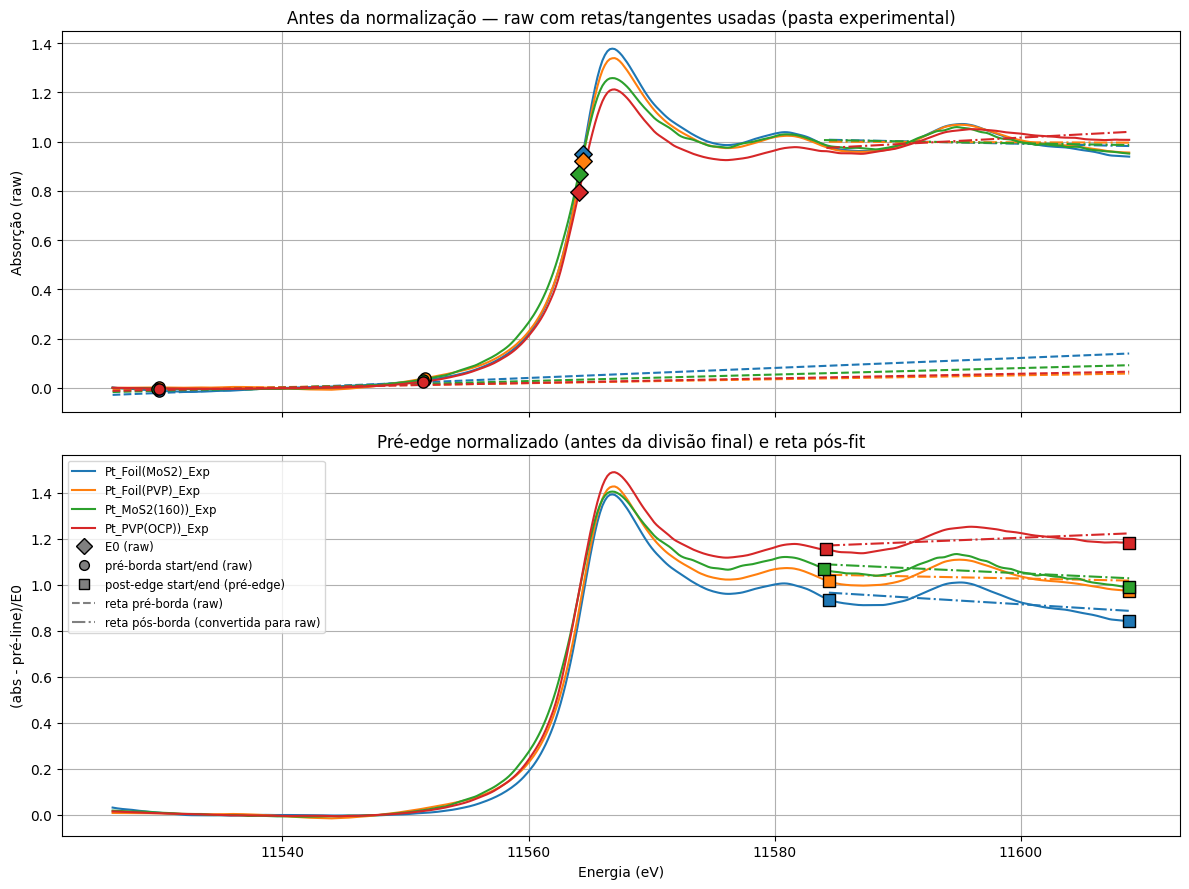

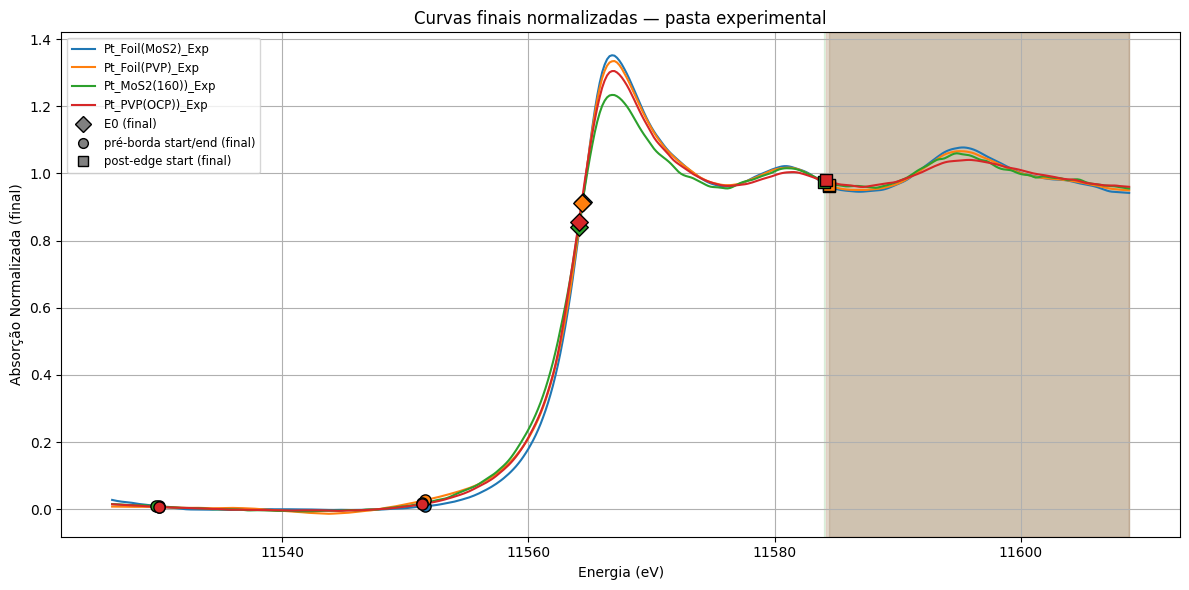


[done] pasta experimental: 4 arquivos normalizados salvos em 'normalized'
   normalized\XANES_Pt_Foil(MoS2)_Exp_norm.txt
   normalized\XANES_Pt_Foil(PVP)_Exp_norm.txt
   normalized\XANES_Pt_MoS2(160))_Exp_norm.txt
   normalized\XANES_Pt_PVP(OCP))_Exp_norm.txt
Plots salvos: plots\experimental_raw_preedge.png, plots\experimental_final_norm.png



C:\Users\carlos23036\AppData\Local\Temp\ipykernel_17144\3833036081.py:47: RuntimeWarning: divide by zero encountered in divide
  d = np.diff(a_s) / np.diff(energies)
C:\Users\carlos23036\AppData\Roaming\Python\Python310\site-packages\numpy\lib\function_base.py:1448: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])
C:\Users\carlos23036\AppData\Local\Temp\ipykernel_17144\4218809280.py:132: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig1.tight_layout()
C:\Users\carlos23036\AppData\Local\Temp\ipykernel_17144\4218809280.py:149: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig2.tight_layout()


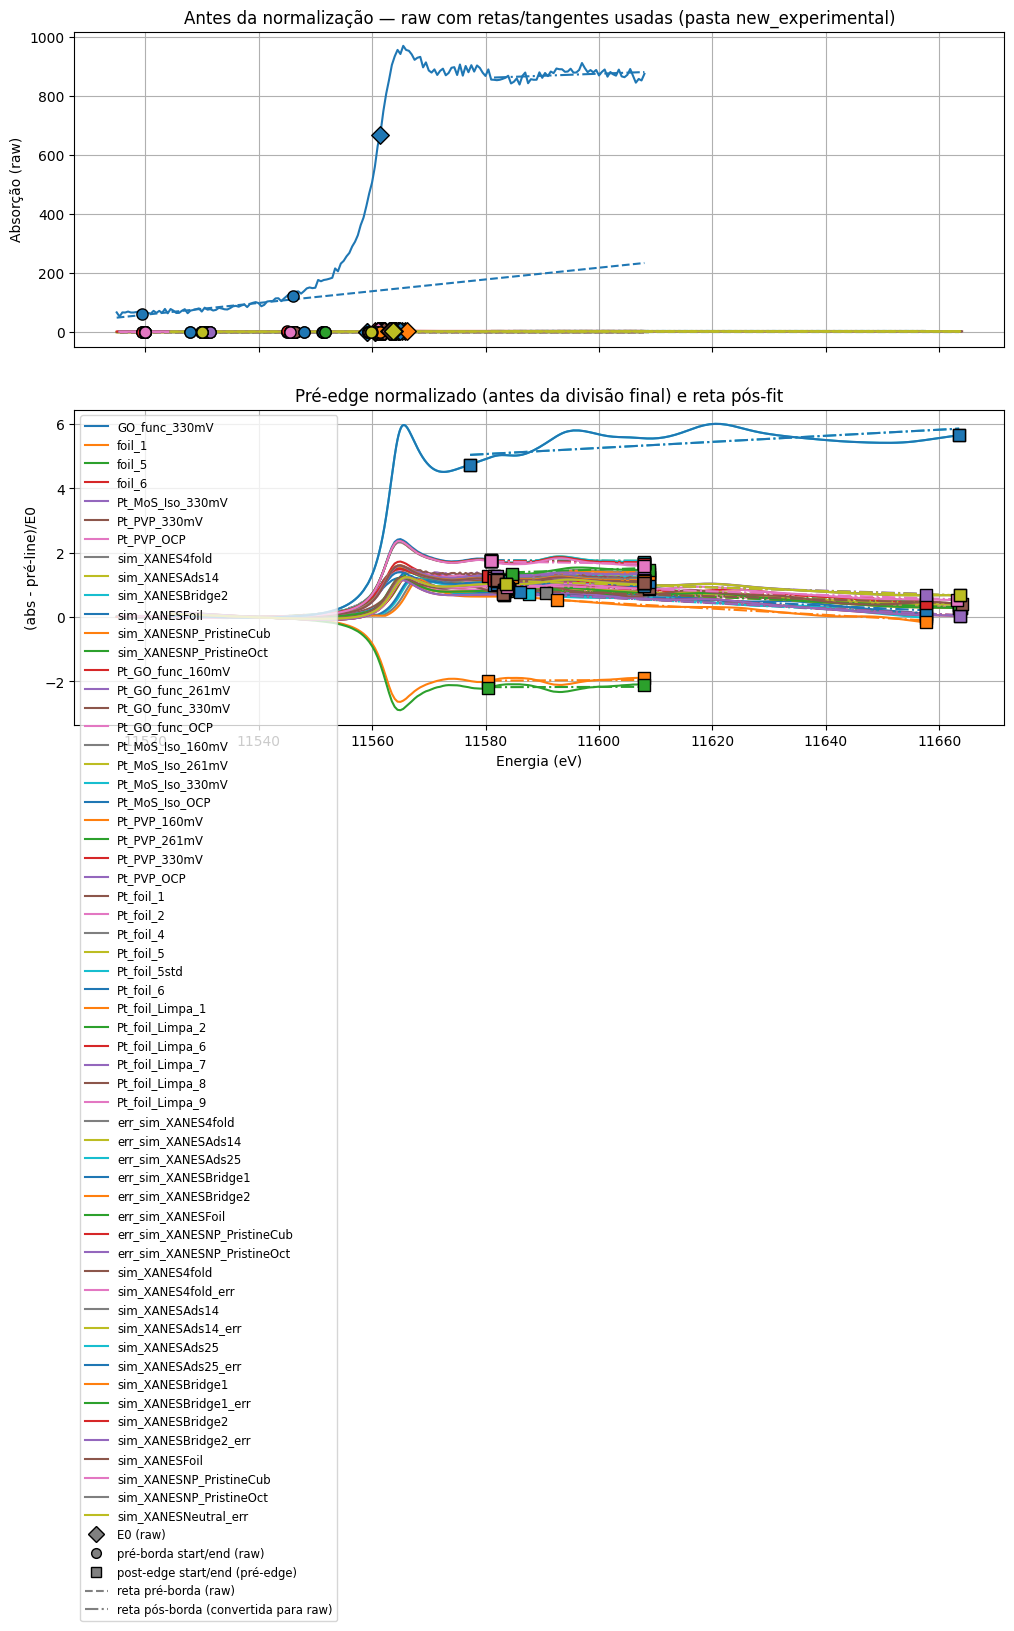

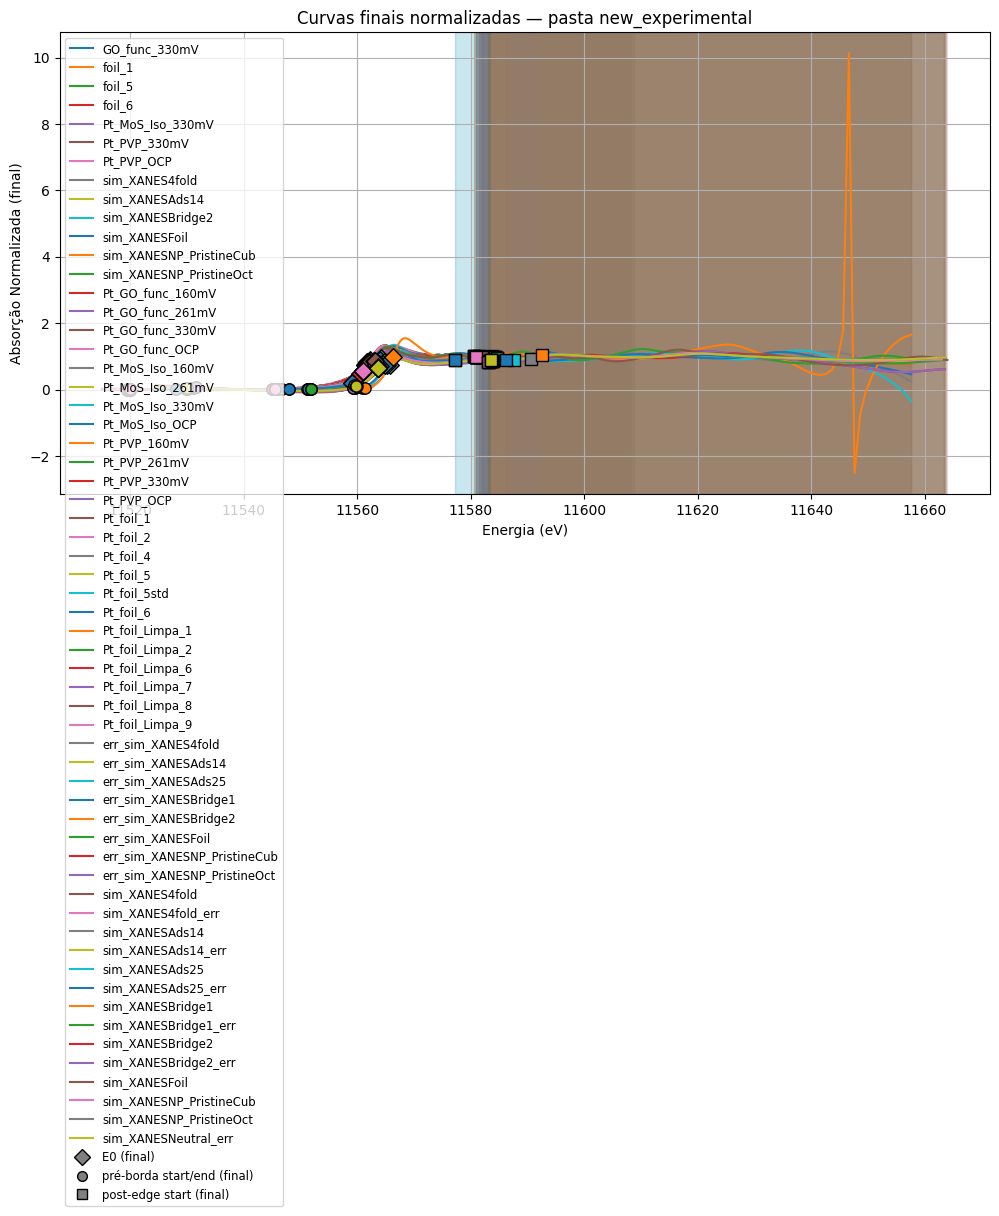


[done] pasta new_experimental: 59 arquivos normalizados salvos em 'normalized'
   normalized\Pt_GO_func_330mV_norm.txt
   normalized\Pt_foil_1_norm.txt
   normalized\Pt_foil_5_norm.txt
   normalized\Pt_foil_6_norm.txt
   normalized\interp_Pt_MoS_Iso_330mV_norm.txt
   normalized\interp_Pt_PVP_330mV_norm.txt
   normalized\interp_Pt_PVP_OCP_norm.txt
   normalized\interp_sim_XANES4fold_norm.txt
   normalized\interp_sim_XANESAds14_norm.txt
   normalized\interp_sim_XANESBridge2_norm.txt
   normalized\interp_sim_XANESFoil_norm.txt
   normalized\interp_sim_XANESNP_PristineCub_norm.txt
   normalized\interp_sim_XANESNP_PristineOct_norm.txt
   normalized\norm_Pt_GO_func_160mV_norm.txt
   normalized\norm_Pt_GO_func_261mV_norm.txt
   normalized\norm_Pt_GO_func_330mV_norm.txt
   normalized\norm_Pt_GO_func_OCP_norm.txt
   normalized\norm_Pt_MoS_Iso_160mV_norm.txt
   normalized\norm_Pt_MoS_Iso_261mV_norm.txt
   normalized\norm_Pt_MoS_Iso_330mV_norm.txt
   normalized\norm_Pt_MoS_Iso_OCP_norm.txt
   no

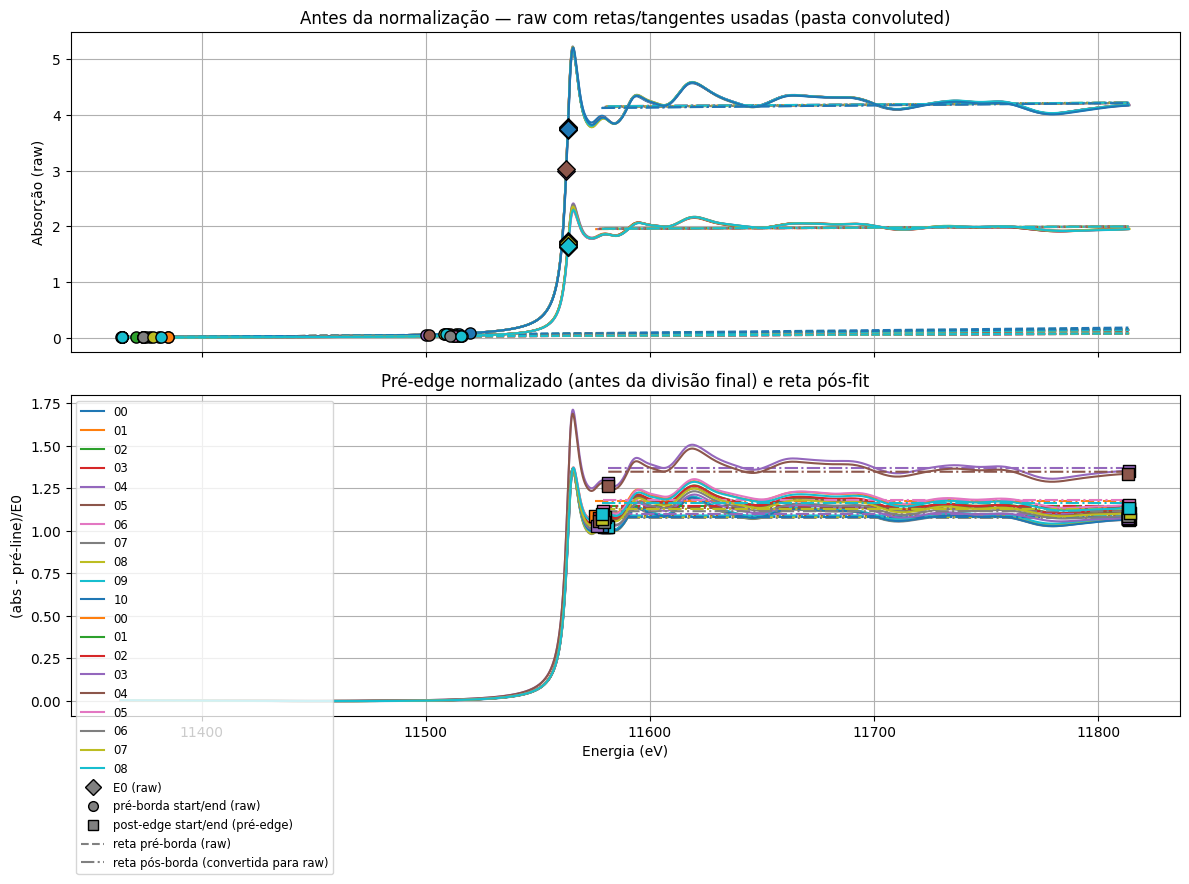

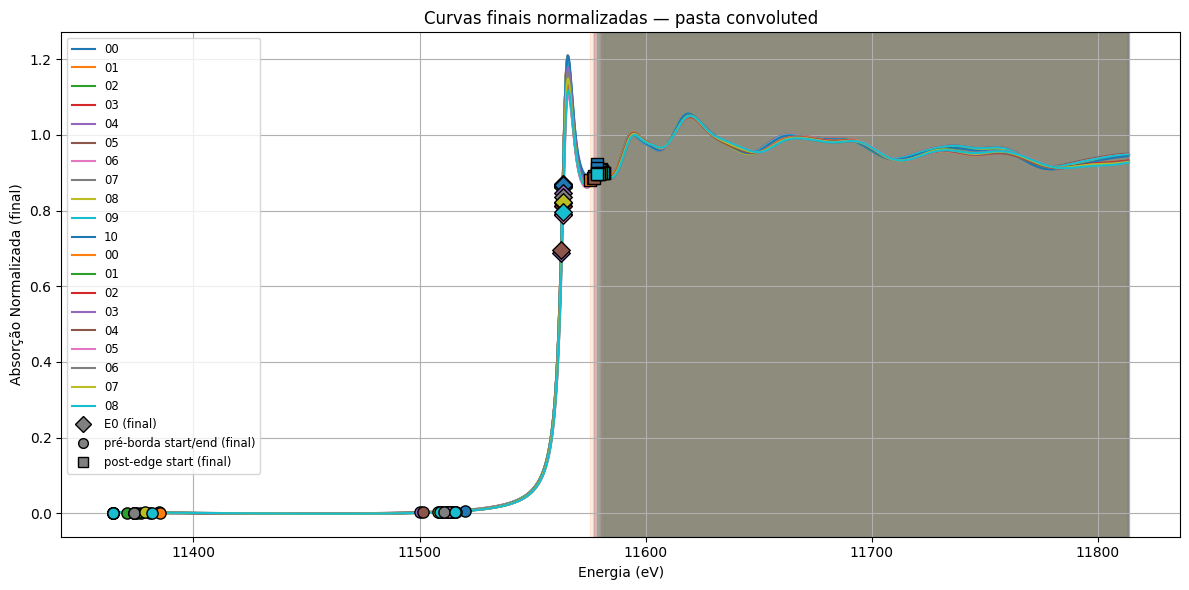


[done] pasta convoluted: 20 arquivos normalizados salvos em 'normalized'
   normalized\116_00_norm.txt
   normalized\116_01_norm.txt
   normalized\116_02_norm.txt
   normalized\116_03_norm.txt
   normalized\116_04_norm.txt
   normalized\116_05_norm.txt
   normalized\116_06_norm.txt
   normalized\116_07_norm.txt
   normalized\116_08_norm.txt
   normalized\116_09_norm.txt
   normalized\116_10_norm.txt
   normalized\55_00_norm.txt
   normalized\55_01_norm.txt
   normalized\55_02_norm.txt
   normalized\55_03_norm.txt
   normalized\55_04_norm.txt
   normalized\55_05_norm.txt
   normalized\55_06_norm.txt
   normalized\55_07_norm.txt
   normalized\55_08_norm.txt
Plots salvos: plots\convoluted_raw_preedge.png, plots\convoluted_final_norm.png



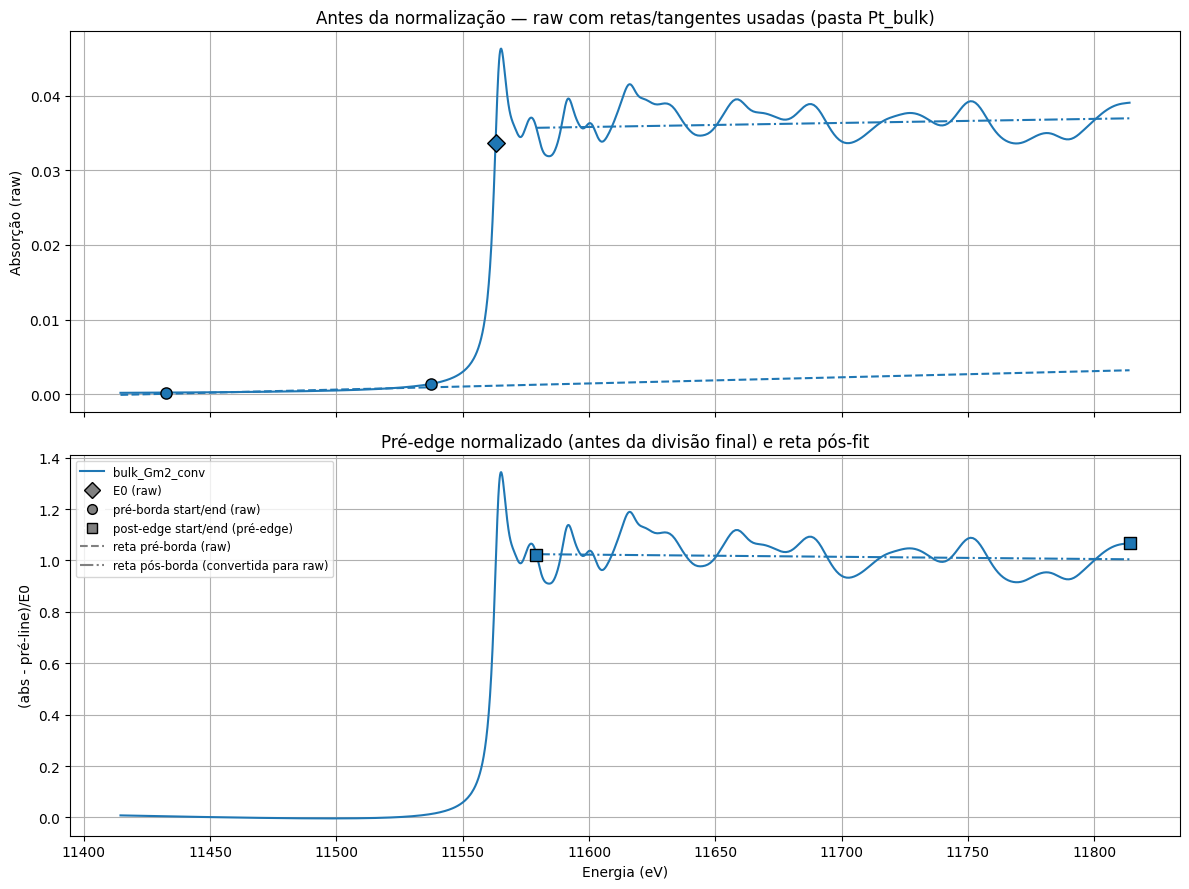

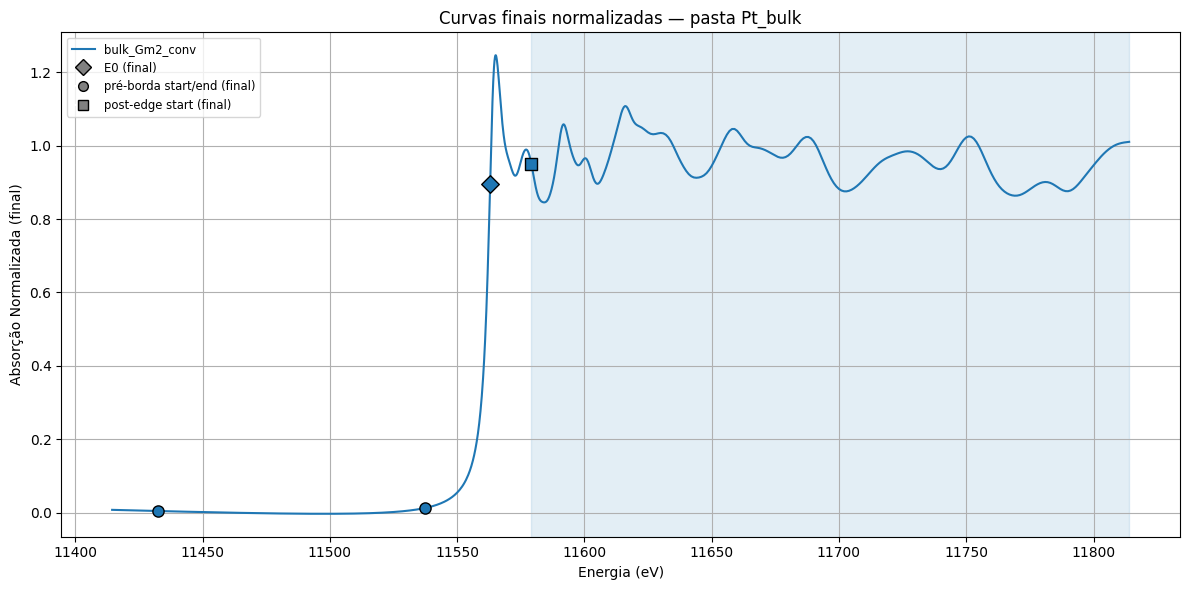


[done] pasta Pt_bulk: 1 arquivos normalizados salvos em 'normalized'
   normalized\Pt_bulk_Gm2_conv_norm.txt
Plots salvos: plots\Pt_bulk_raw_preedge.png, plots\Pt_bulk_final_norm.png



In [6]:

# Execução 
if __name__ == "__main__":
    FOLDERS = pastas
    ensure_dir(OUTPUT_DIR)
    ensure_dir(PLOTS_DIR)

    for folder in FOLDERS:
        folder_path = os.path.join('.', folder)
        # escolhe rótulos apropriados (caso suas pastas sejam '55' e '116')
        if os.path.basename(folder) == '55':
            labels = site_labels_55
        elif os.path.basename(folder) == '116':
            labels = site_labels_116
        else:
            labels = {}

        process_particle_in_folder(folder_path, labels,
                                    cut=CUT,
                                    output_dir=OUTPUT_DIR,
                                    plots_dir=PLOTS_DIR,
                                    smooth_sigma=SMOOTH_SIGMA,
                                    min_post_edge_eV=MIN_POST_EDGE_EVMIN,
                                    rescale_window=RESCALE_WINDOW)

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict

# -------- CONFIG --------
NORM_DIR = "normalized"
PLOTS_DIR = "plots_final"
os.makedirs(PLOTS_DIR, exist_ok=True)

# -------- Mapas de rótulos dos sítios --------
site_labels_55 = {
    '00': 'pristina',
    '01': 'ontop',
    '02': 'bridge',
    '03': 'fcc',
    '04': 'hcp',
    '05': '4fold',
    '06': 'bridge',
    '07': 'ontop',
    '08': 'ontop',
}

site_labels_116 = {
    '00': 'pristina',
    '01': 'ontop',
    '02': 'bridge',
    '03': 'fcc',
    '04': 'bridge',
    '05': 'hcp',
    '06': '4fold',
    '07': 'ontop',
    '08': 'ontop',
    '09': 'bridge',
    '10': 'ontop',
}

# -------- Funções utilitárias --------
def load_norm_file(fname):
    data = np.loadtxt(fname, comments="#")
    E = data[:, 0]
    final = data[:, -1]
    return E, final

def interp_to_ref(E_ref, E, mu):
    return np.interp(E_ref, E, mu)

def site_label(fname):
    base = os.path.basename(fname)
    if base.startswith("55_"):
        parts = base.split("_")
        if len(parts) >= 2:
            key = parts[1]
            return site_labels_55.get(key, base.replace("_norm.txt",""))
    if base.startswith("116_"):
        parts = base.split("_")
        if len(parts) >= 2:
            key = parts[1]
            return site_labels_116.get(key, base.replace("_norm.txt",""))
    return base.replace("_norm.txt","")

# Paleta de cores
palette = [
    "brown",
    "blue",
    "purple",
    "r",
    "pink",
    "gray",
    "#17becf",
    "#bcbd22",
    "#393b79",
    "#637939",
]

linestyles = ['-', '--', ':', '-.']

def build_site_color_map():
    unique_sites = []
    for d in (site_labels_55, site_labels_116):
        for v in d.values():
            if v not in unique_sites:
                unique_sites.append(v)
    cmap = OrderedDict()
    pal_len = len(palette)
    for i, site in enumerate(unique_sites):
        cmap[site] = palette[i % pal_len]
    return cmap

SITE_COLOR = build_site_color_map()

# -------- Funções de plot --------
def plot_all(E, curves, labels, colors=None, lss=None, title="", fname="", exp_limits=None, fig_num=None, show=True):
    if fig_num is not None:
        plt.figure(fig_num, figsize=(8,6))
    else:
        plt.figure(figsize=(8,6))

    for i, mu in enumerate(curves):
        lbl = labels[i] if labels is not None else None
        color = colors[i] if (colors is not None and i < len(colors)) else None
        ls = lss[i] if (lss is not None and i < len(lss)) else '-'
        plt.plot(E, mu, label=lbl, color=color, linestyle=ls)

    if exp_limits is not None:
        plt.xlim(exp_limits)
    plt.xlabel("Energia (eV)")
    plt.ylabel("Absorção Normalizada")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(fname, dpi=300)
    if show:
        plt.show()
    else:
        plt.close()

def plot_delta(E, curves, labels, colors=None, lss=None, title="", fname="", exp_limits=None, fig_num=None, show=True):
    if fig_num is not None:
        plt.figure(fig_num, figsize=(8,6))
    else:
        plt.figure(figsize=(8,6))

    for i, mu in enumerate(curves):
        lbl = labels[i] if labels is not None else None
        color = colors[i] if (colors is not None and i < len(colors)) else None
        ls = lss[i] if (lss is not None and i < len(lss)) else '-'
        plt.plot(E, mu, label=lbl, color=color, linestyle=ls)

    if exp_limits is not None:
        plt.xlim(exp_limits)
    plt.axhline(0, color="k", linewidth=0.8)
    plt.xlabel("Energia (eV)")
    plt.ylabel("Δμ")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xlim(11550, 11580)
    plt.tight_layout()
    plt.savefig(fname, dpi=300)
    if show:
        plt.show()
    else:
        plt.close()

# -------- Carregar arquivos --------
files = glob.glob(os.path.join(NORM_DIR, "*_norm.txt"))
files_55 = sorted([f for f in files if os.path.basename(f).startswith("55_")], key=os.path.basename)
files_116 = sorted([f for f in files if os.path.basename(f).startswith("116_")], key=os.path.basename)

# experimental e bulk
exp_files = [f for f in files if "XANES_Pt_Foil" in f or "XANES_Pt_MoS2(160)" in f]
if len(exp_files) < 2:
    raise RuntimeError("Arquivos experimentais não encontrados.")
bulk_candidates = [f for f in files if "Pt_bulk" in f]
if not bulk_candidates:
    raise RuntimeError("Arquivo Pt_bulk não encontrado.")
bulk_file = bulk_candidates[0]

# experimental
exp_mos2foil = [f for f in exp_files if "Foil(MoS2)" in f][0]
exp_mos2160 = [f for f in exp_files if "MoS2(160)" in f][0]
E_exp, mu_exp_foil = load_norm_file(exp_mos2foil)
_, mu_exp_160 = load_norm_file(exp_mos2160)
delta_exp = mu_exp_foil - mu_exp_160
exp_limits = (E_exp.min(), E_exp.max())

# Pt bulk
E_bulk, mu_bulk = load_norm_file(bulk_file)

def assign_styles(file_list):
    site_counter = defaultdict(int)
    colors = []
    lss = []
    labels = []
    for f in file_list:
        site = site_label(f)
        color = SITE_COLOR.get(site, "#333333")
        idx = site_counter[site]
        ls = linestyles[idx % len(linestyles)]
        site_counter[site] += 1
        colors.append(color)
        lss.append(ls)
        labels.append(site)
    return colors, lss, labels

# -------- Gráficos --------

# 1) todas as curvas 55 + experimental foil
curves_55_interp = [interp_to_ref(E_exp, *load_norm_file(f)) for f in files_55]
colors_55, lss_55, labels_55 = assign_styles(files_55)
curves1 = curves_55_interp + [mu_exp_foil]
colors1 = colors_55 + ['k']
lss1 = lss_55 + ['--']
labels1 = labels_55 + ['Exp Foil']

plot_all(E_exp, curves1, labels1, colors=colors1, lss=lss1,
         title="55 átomos + Experimental (MoS2 foil)",
         fname=os.path.join(PLOTS_DIR, "55_expfoil.png"),
         exp_limits=exp_limits, fig_num=1, show=True)

# 2) Δμ 55 - bulk + Δμ exp
delta_files_55 = [f for f in files_55 if os.path.basename(f).split("_")[1] != "00"]
curves = []
colors = []
lss = []
labels = []
site_counter = defaultdict(int)
mu_bulk_interp = interp_to_ref(E_exp, E_bulk, mu_bulk)
for f in delta_files_55:
    E, mu = load_norm_file(f)
    mu = interp_to_ref(E_exp, E, mu)
    curves.append(mu - mu_bulk_interp)
    site = site_label(f)
    color = SITE_COLOR.get(site, "#333333")
    idx = site_counter[site]
    ls = linestyles[idx % len(linestyles)]
    site_counter[site] += 1
    colors.append(color)
    lss.append(ls)
    labels.append(f"{site} - Pt bulk")

curves.append(delta_exp)
colors.append('k')
lss.append('--')
labels.append("Exp Δμ (160 - Foil)")

plot_delta(E_exp, curves, labels, colors=colors, lss=lss,
           title="Δμ 55 - Pt bulk", fname=os.path.join(PLOTS_DIR, "55_delta_bulk.png"),
           exp_limits=exp_limits, fig_num=2, show=True)

# 3) todas as curvas 116 + experimental foil
curves_116_interp = [interp_to_ref(E_exp, *load_norm_file(f)) for f in files_116]
colors_116, lss_116, labels_116 = assign_styles(files_116)
curves3 = curves_116_interp + [mu_exp_foil]
colors3 = colors_116 + ['k']
lss3 = lss_116 + ['--']
labels3 = labels_116 + ['Exp Foil']

plot_all(E_exp, curves3, labels3, colors=colors3, lss=lss3,
         title="116 átomos + Experimental (MoS2 foil)",
         fname=os.path.join(PLOTS_DIR, "116_expfoil.png"),
         exp_limits=exp_limits, fig_num=3, show=True)

# 4) Δμ 116 - bulk + Δμ exp
delta_files_116 = [f for f in files_116 if os.path.basename(f).split("_")[1] != "00"]
curves = []
colors = []
lss = []
labels = []
site_counter = defaultdict(int)
mu_bulk_interp = interp_to_ref(E_exp, E_bulk, mu_bulk)
for f in delta_files_116:
    E, mu = load_norm_file(f)
    mu = interp_to_ref(E_exp, E, mu)
    curves.append(mu - mu_bulk_interp)
    site = site_label(f)
    color = SITE_COLOR.get(site, "#333333")
    idx = site_counter[site]
    ls = linestyles[idx % len(linestyles)]
    site_counter[site] += 1
    colors.append(color)
    lss.append(ls)
    labels.append(f"{site} - Pt bulk")

curves.append(delta_exp)
colors.append('k')
lss.append('--')
labels.append("Exp Δμ (160 - Foil)")

plot_delta(E_exp, curves, labels, colors=colors, lss=lss,
           title="Δμ 116 - Pt bulk", fname=os.path.join(PLOTS_DIR, "116_delta_bulk.png"),
           exp_limits=exp_limits, fig_num=4, show=True)

print("Todos os gráficos foram salvos em:", PLOTS_DIR)


IndexError: list index out of range

- rmse puro
- retirar delta g maiores modulos
- tentar outros métodos

[55atoms] usando intervalo (11500.0, 11620.0) -> pontos = 414
Salvo por-sítio em: plots_final\delta_analysis_55atoms_per_site.csv
[55atoms] Lasso alpha=3.481e-01 rmse=2.2405e-02 positive=True
Salvo Lasso coefs em: plots_final\delta_analysis_55atoms_lasso_coefs.csv
Salvo combinações top2 em: plots_final\delta_analysis_55atoms_best_combo2.csv
Salvo combinações top3 em: plots_final\delta_analysis_55atoms_best_combo3.csv


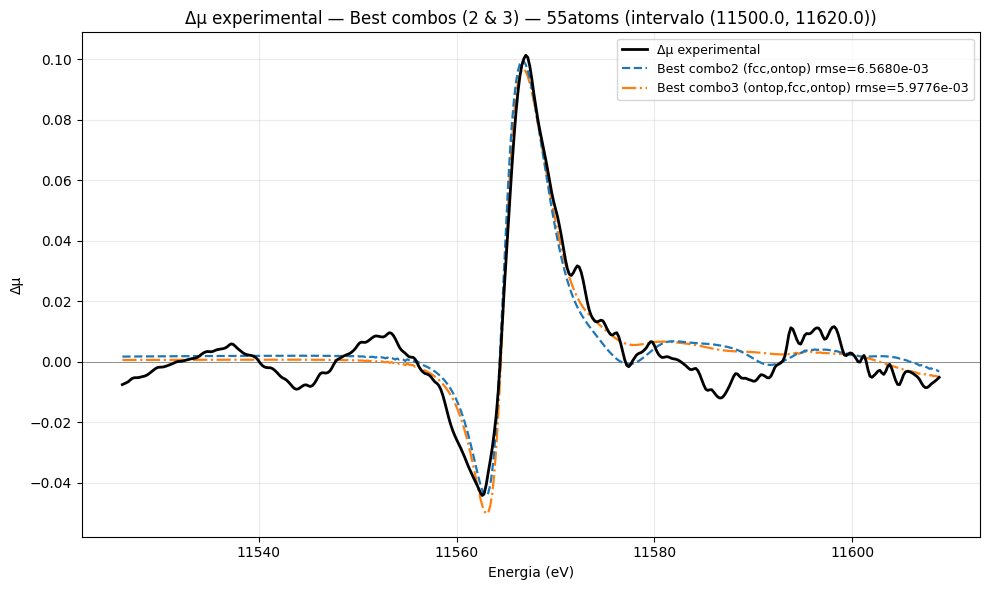

Plot salvo em: plots_final\delta_analysis_55atoms_best_combos.png
[116atoms] usando intervalo (11500.0, 11620.0) -> pontos = 414
Salvo por-sítio em: plots_final\delta_analysis_116atoms_per_site.csv
[116atoms] Lasso alpha=3.535e-01 rmse=2.2405e-02 positive=True
Salvo Lasso coefs em: plots_final\delta_analysis_116atoms_lasso_coefs.csv
Salvo combinações top2 em: plots_final\delta_analysis_116atoms_best_combo2.csv
Salvo combinações top3 em: plots_final\delta_analysis_116atoms_best_combo3.csv


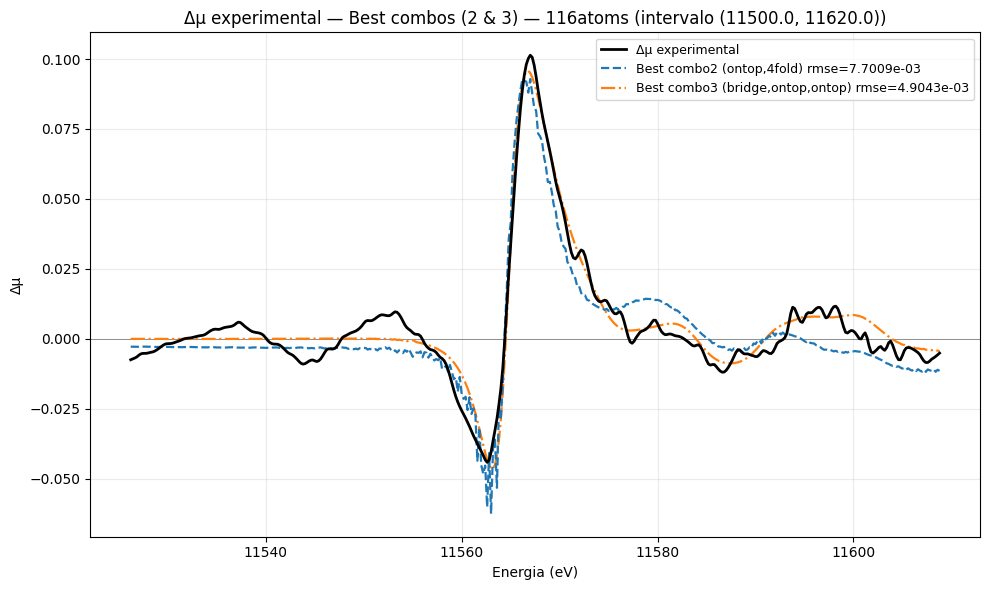

Plot salvo em: plots_final\delta_analysis_116atoms_best_combos.png

=== Execução concluída ===
Arquivos gerados em: plots_final


In [56]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
delta_best_combos_only.py

- Faz corte em intervalo de energia antes das análises.
- Calcula correlação e RMSE por sítio.
- Roda LassoCV (salva coeficientes).
- Busca combinações de 2 e 3 sítios (lsq e nnls) e salva CSVs.
- **Plota apenas um gráfico por conjunto** contendo:
    Δµ experimental + best combo2 (LSQ) + best combo3 (LSQ)
- Requisitos: numpy, scipy, matplotlib, scikit-learn, pandas
"""
import os
import glob
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import nnls
from scipy.stats import pearsonr

# scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV

# -------- CONFIG --------
NORM_DIR = "normalized"
PLOTS_DIR = "plots_final"
os.makedirs(PLOTS_DIR, exist_ok=True)

OUT_PREFIX = "delta_analysis"   # prefix para CSVs
ENERGY_RANGE = (11500.0, 11620.0)   # <= definir None para usar todo o intervalo
TOP_N_COMBOS = 10   # quantas melhores combinações listar para cada tamanho (2 e 3)

# -------- Mapas de rótulos (ajuste se necessário) --------
site_labels_55 = {
    '00': 'pristina', '01': 'ontop', '02': 'bridge', '03': 'fcc',
    '04': 'hcp', '05': '4fold', '06': 'bridge', '07': 'ontop', '08': 'ontop'
}
site_labels_116 = {
    '00': 'pristina', '01': 'ontop', '02': 'bridge', '03': 'fcc',
    '04': 'bridge', '05': 'hcp', '06': '4fold', '07': 'ontop',
    '08': 'ontop', '09': 'bridge', '10': 'ontop'
}

# -------- utilitárias --------
def load_norm_file(fname):
    data = np.loadtxt(fname, comments="#")
    E = data[:, 0]
    final = data[:, -1]
    return E, final

def interp_to_ref(E_ref, E, mu):
    return np.interp(E_ref, E, mu)

def site_label(fname):
    base = os.path.basename(fname)
    if base.startswith("55_"):
        parts = base.split("_")
        if len(parts) >= 2:
            return site_labels_55.get(parts[1], base.replace("_norm.txt",""))
    if base.startswith("116_"):
        parts = base.split("_")
        if len(parts) >= 2:
            return site_labels_116.get(parts[1], base.replace("_norm.txt",""))
    return base.replace("_norm.txt","")

def rmse(a, b):
    return float(np.sqrt(np.mean((a - b)**2)))

# -------- Ler arquivos --------
files = glob.glob(os.path.join(NORM_DIR, "*_norm.txt"))
files_55 = sorted([f for f in files if os.path.basename(f).startswith("55_")])
files_116 = sorted([f for f in files if os.path.basename(f).startswith("116_")])

# detectar experimentais e bulk (ajuste conforme seu padrão)
exp_files = [f for f in files if ("XANES_Pt_Foil" in f) or ("XANES_Pt_MoS2" in f) or ("Foil" in f and "MoS2" in f)]
if len(exp_files) < 2:
    # fallback: tentar qualquer arquivo que contenha 'Foil' e outro que contenha '160'
    exp_files = [f for f in files if "Foil" in os.path.basename(f) or "160" in os.path.basename(f)]
if len(exp_files) < 2:
    raise RuntimeError("Arquivos experimentais não encontrados em 'normalized' (procure por 'XANES_Pt_Foil' / 'MoS2' / 'Foil' / '160').")
bulk_candidates = [f for f in files if "Pt_bulk" in f or "bulk" in os.path.basename(f).lower()]
if not bulk_candidates:
    raise RuntimeError("Arquivo Pt_bulk não encontrado (procure por 'Pt_bulk' em 'normalized').")
bulk_file = bulk_candidates[0]

# heurística para escolher os dois experimentais usados no delta (ajuste se necessário)
exp_foil = None
exp_160 = None
for f in exp_files:
    if "Foil" in os.path.basename(f) or "Foil" in f:
        exp_foil = f
    if "160" in os.path.basename(f) or "160" in f:
        exp_160 = f
if exp_foil is None or exp_160 is None:
    # fallback: usar os dois primeiros
    exp_foil = exp_files[0]
    exp_160 = exp_files[1]

E_exp_full, mu_exp_foil = load_norm_file(exp_foil)
_, mu_exp_160 = load_norm_file(exp_160)
delta_exp_full = mu_exp_foil - mu_exp_160

E_bulk, mu_bulk = load_norm_file(bulk_file)
mu_bulk_interp_full = interp_to_ref(E_exp_full, E_bulk, mu_bulk)

# -------- Construir Δµ de cada sítio (excluindo pristina) --------
def build_delta_matrix_for_files(files_list, E_ref, mu_bulk_interp_ref):
    curves, names = [], []
    for f in files_list:
        parts = os.path.basename(f).split("_")
        if len(parts) >= 2 and parts[1] == "00":  # pular pristina se index '00'
            continue
        E, mu = load_norm_file(f)
        mu_interp = interp_to_ref(E_ref, E, mu)
        delta = mu_interp - mu_bulk_interp_ref
        curves.append(delta)
        names.append(site_label(f))
    if len(curves) == 0:
        return np.zeros((len(E_ref),0)), []
    return np.array(curves).T, names  # shape (n_points, n_sites)

delta_55_full, names_55 = build_delta_matrix_for_files(files_55, E_exp_full, mu_bulk_interp_full)
delta_116_full, names_116 = build_delta_matrix_for_files(files_116, E_exp_full, mu_bulk_interp_full)

# -------- Função para recortar por energia --------
def apply_energy_cut(E_full, y_full, X_full, energy_range):
    if energy_range is None:
        return E_full, y_full, X_full
    emin, emax = energy_range
    mask = (E_full >= emin) & (E_full <= emax)
    if mask.sum() == 0:
        raise RuntimeError(f"Nenhum ponto dentro do intervalo {energy_range}.")
    return E_full[mask], y_full[mask], X_full[mask, :] if X_full.size else X_full

# -------- Função para encontrar melhores combinações (size = 2 ou 3) --------
def best_combinations_by_rmse(X, y, names, comb_size=2, top_n=10, enforce_nonneg=True, allow_intercept=False):
    """
    Percorre todas combinações de 'comb_size' colunas de X. Para cada combinação:
      - resolve LSQ (com ou sem intercepto)
      - também resolve NNLS se enforce_nonneg True
    Retorna lista de dicionários ordenada por lsq_rmse (asc).
    """
    n_sites = X.shape[1]
    combos = list(itertools.combinations(range(n_sites), comb_size))
    out = []
    for comb in combos:
        cols = list(comb)
        Xsub = X[:, cols]  # (n_points, comb_size)

        # 1) least squares com intercept opcional
        if allow_intercept:
            A = np.hstack([Xsub, np.ones((Xsub.shape[0], 1))])
            sol, *_ = np.linalg.lstsq(A, y, rcond=None)
            coefs = sol[:-1]
            intercept = sol[-1]
            ypred = A.dot(sol)
        else:
            sol, *_ = np.linalg.lstsq(Xsub, y, rcond=None)
            coefs = sol
            intercept = 0.0
            ypred = Xsub.dot(sol)

        lsq_rmse = rmse(y, ypred)

        # 2) nnls (se enforce_nonneg)
        nnls_coefs = None
        nnls_rmse = None
        if enforce_nonneg:
            try:
                c_nnls, _ = nnls(Xsub, y)
                ypred_nnls = Xsub.dot(c_nnls)
                nnls_rmse = rmse(y, ypred_nnls)
                nnls_coefs = c_nnls
            except Exception:
                nnls_coefs = None
                nnls_rmse = None

        out.append({
            "indices": cols,
            "sites": [names[i] for i in cols],
            "lsq_coefs": np.asarray(coefs),
            "lsq_intercept": float(intercept),
            "lsq_rmse": float(lsq_rmse),
            "nnls_coefs": np.asarray(nnls_coefs) if nnls_coefs is not None else None,
            "nnls_rmse": float(nnls_rmse) if nnls_rmse is not None else None
        })

    out_sorted = sorted(out, key=lambda x: x["lsq_rmse"])
    return out_sorted[:min(top_n, len(out_sorted))]

# -------- Função de análise completa para um conjunto (55 ou 116) --------
def analyze_and_save(E_full, delta_full, delta_matrix_full, names, set_label):
    # aplicar corte
    E, y, X = apply_energy_cut(E_full, delta_full, delta_matrix_full, ENERGY_RANGE)
    print(f"[{set_label}] usando intervalo {ENERGY_RANGE} -> pontos = {len(E)}")

    # por-sítio: pearson e rmse (se houver sites)
    per_rs, per_ps, per_rmses = [], [], []
    if X.size:
        for i in range(X.shape[1]):
            xi = X[:, i]
            try:
                r, p = pearsonr(xi, y)
            except Exception:
                r, p = np.corrcoef(xi, y)[0,1], np.nan
            per_rs.append(float(r))
            per_ps.append(float(p))
            per_rmses.append(rmse(xi, y))
    else:
        print(f"[{set_label}] Aviso: matriz de sítios vazia.")
    df_sites = pd.DataFrame({
        "site": names,
        "pearson_r": per_rs,
        "pearson_p": per_ps,
        "rmse": per_rmses
    }).sort_values("rmse").reset_index(drop=True) if len(per_rs)>0 else pd.DataFrame(columns=["site","pearson_r","pearson_p","rmse"])

    # salvar per-site
    csv_sites = os.path.join(PLOTS_DIR, f"{OUT_PREFIX}_{set_label}_per_site.csv")
    df_sites.to_csv(csv_sites, index=False)
    print(f"Salvo por-sítio em: {csv_sites}")

    # LassoCV (padronizar) — mantemos calculo e salvamento, mas NÃO plotamos
    lasso_rmse_val = np.nan
    if X.size:
        scaler_X = StandardScaler(with_mean=True, with_std=True)
        Xs = scaler_X.fit_transform(X)
        scaler_y = StandardScaler(with_mean=True, with_std=True)
        ys = scaler_y.fit_transform(y.reshape(-1,1)).ravel()

        try:
            lasso_cv = LassoCV(cv=5, n_alphas=100, max_iter=5000, positive=True).fit(Xs, ys)
            used_pos = True
        except Exception:
            lasso_cv = LassoCV(cv=5, n_alphas=100, max_iter=5000).fit(Xs, ys)
            used_pos = False

        coef_scaled = lasso_cv.coef_
        X_stds = scaler_X.scale_
        y_std = scaler_y.scale_[0]
        coef_original = coef_scaled * (y_std / X_stds)
        intercept_original = float(scaler_y.mean_[0]) - np.sum(coef_original * scaler_X.mean_)

        y_pred_lasso = X.dot(coef_original) + intercept_original
        lasso_rmse_val = rmse(y, y_pred_lasso)
        print(f"[{set_label}] Lasso alpha={lasso_cv.alpha_:.3e} rmse={lasso_rmse_val:.4e} positive={used_pos}")

        # salvar lasso coefs
        df_lasso = pd.DataFrame({
            "site": names,
            "lasso_coef": coef_original
        }).sort_values("lasso_coef", key=lambda s: np.abs(s), ascending=False).reset_index(drop=True)
    else:
        df_lasso = pd.DataFrame(columns=["site","lasso_coef"])

    csv_lasso = os.path.join(PLOTS_DIR, f"{OUT_PREFIX}_{set_label}_lasso_coefs.csv")
    df_lasso.to_csv(csv_lasso, index=False)
    print(f"Salvo Lasso coefs em: {csv_lasso}")

    # Combinações de 2 e 3 sítios
    combos_2 = best_combinations_by_rmse(X, y, names, comb_size=2, top_n=TOP_N_COMBOS, enforce_nonneg=True, allow_intercept=False) if X.size else []
    combos_3 = best_combinations_by_rmse(X, y, names, comb_size=3, top_n=TOP_N_COMBOS, enforce_nonneg=True, allow_intercept=False) if X.size else []

    def combos_to_df(combos):
        rows = []
        for c in combos:
            rows.append({
                "sites": ";".join(c["sites"]),
                "indices": ",".join(map(str, c["indices"])),
                "lsq_rmse": c["lsq_rmse"],
                "lsq_intercept": c["lsq_intercept"],
                "lsq_coefs": ";".join([f"{v:.6e}" for v in (c["lsq_coefs"] if c["lsq_coefs"] is not None else [])]),
                "nnls_rmse": c["nnls_rmse"] if c["nnls_rmse"] is not None else np.nan,
                "nnls_coefs": (";".join([f"{v:.6e}" for v in c["nnls_coefs"]]) if c["nnls_coefs"] is not None else "")
            })
        return pd.DataFrame(rows)

    df_combo2 = combos_to_df(combos_2)
    df_combo3 = combos_to_df(combos_3)

    csv_combo2 = os.path.join(PLOTS_DIR, f"{OUT_PREFIX}_{set_label}_best_combo2.csv")
    csv_combo3 = os.path.join(PLOTS_DIR, f"{OUT_PREFIX}_{set_label}_best_combo3.csv")
    df_combo2.to_csv(csv_combo2, index=False)
    df_combo3.to_csv(csv_combo3, index=False)
    print(f"Salvo combinações top2 em: {csv_combo2}")
    print(f"Salvo combinações top3 em: {csv_combo3}")

    # -------- Plots reduzidos: apenas Δµ experimental + best combo2 (lsq) + best combo3 (lsq) --------
    plt.figure(figsize=(10,6))
    plt.plot(E, y, linestyle='-', linewidth=2.0, label="Δµ experimental", zorder=10, color='black')

    # best combo2 (lsq)
    if len(combos_2) > 0:
        best2 = combos_2[0]
        cols2 = best2["indices"]
        # proteger caso X tenha 0 colunas
        try:
            y_best2 = X[:, cols2].dot(best2["lsq_coefs"])
            plt.plot(E, y_best2, linestyle='--', linewidth=1.6,
                     label=f"Best combo2 ({','.join(best2['sites'])}) rmse={best2['lsq_rmse']:.4e}", zorder=9)
        except Exception:
            print(f"[{set_label}] Não foi possível montar curva best combo2 (erro com índices {cols2}).")

    else:
        print(f"[{set_label}] Nenhuma combinação de 2 sítios disponível para plot.")

    # best combo3 (lsq)
    if len(combos_3) > 0:
        best3 = combos_3[0]
        cols3 = best3["indices"]
        try:
            y_best3 = X[:, cols3].dot(best3["lsq_coefs"])
            plt.plot(E, y_best3, linestyle='-.', linewidth=1.6,
                     label=f"Best combo3 ({','.join(best3['sites'])}) rmse={best3['lsq_rmse']:.4e}", zorder=8)
        except Exception:
            print(f"[{set_label}] Não foi possível montar curva best combo3 (erro com índices {cols3}).")
    else:
        print(f"[{set_label}] Nenhuma combinação de 3 sítios disponível para plot.")

    plt.axhline(0, color='gray', lw=0.6)
    plt.xlabel("Energia (eV)")
    plt.ylabel("Δµ")
    plt.title(f"Δµ experimental — Best combos (2 & 3) — {set_label} (intervalo {ENERGY_RANGE})")
    plt.legend(fontsize=9, loc='best')
    plt.grid(alpha=0.25)
    plt.tight_layout()
    figfile = os.path.join(PLOTS_DIR, f"{OUT_PREFIX}_{set_label}_best_combos.png")
    plt.savefig(figfile, dpi=300)
    plt.show()
    print(f"Plot salvo em: {figfile}")

    # retornar DataFrames e combos
    return {
        "df_sites": df_sites,
        "df_lasso": df_lasso,
        "df_combo2": df_combo2,
        "df_combo3": df_combo3,
        "summary": {
            "lasso_rmse": lasso_rmse_val,
            "n_points": len(E),
            "n_sites": X.shape[1] if X.size else 0
        }
    }

# -------- Executar para 55 e 116 --------
res55 = analyze_and_save(E_exp_full, delta_exp_full, delta_55_full, names_55, set_label="55atoms")
res116 = analyze_and_save(E_exp_full, delta_exp_full, delta_116_full, names_116, set_label="116atoms")

print("\n=== Execução concluída ===")
print("Arquivos gerados em:", PLOTS_DIR)


[55atoms] pontos = 414 | sítios = 8


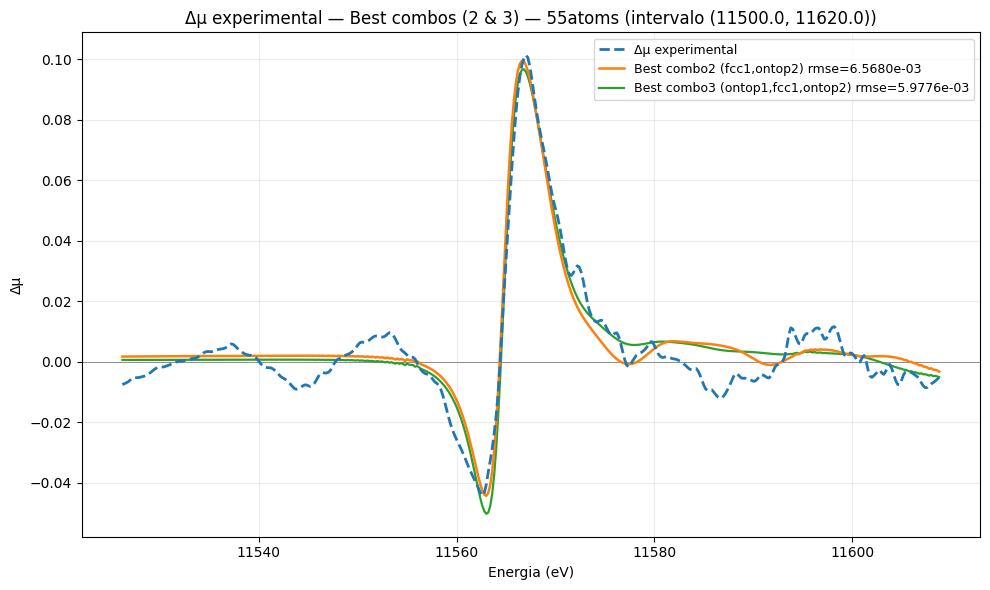

[55atoms] plot salvo: plots_final\delta_best_combos_55atoms.png
[116atoms] pontos = 414 | sítios = 10


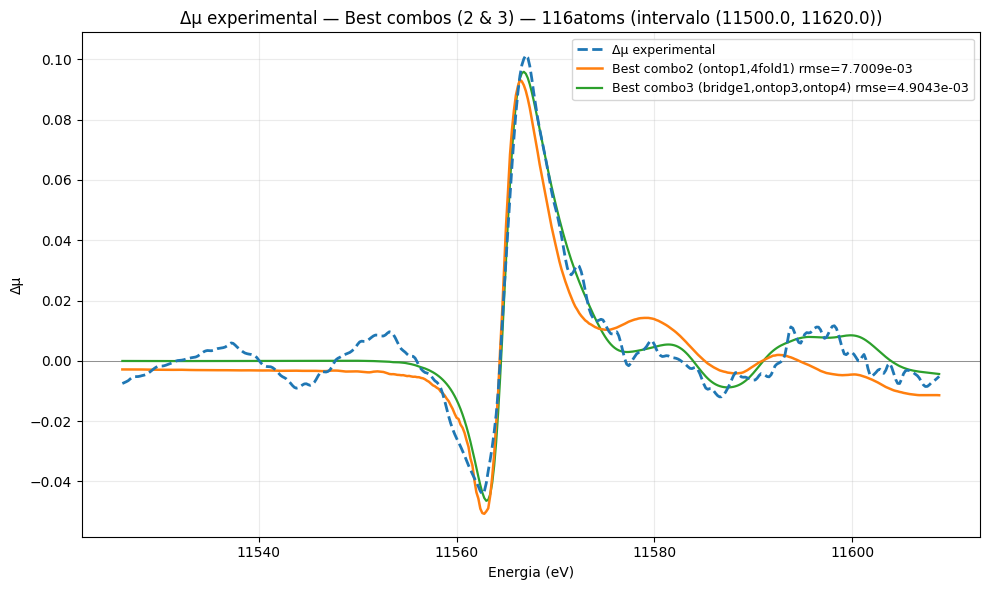

[116atoms] plot salvo: plots_final\delta_best_combos_116atoms.png
Pronto — plots gerados em: plots_final


In [37]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
delta_best_combos_plot_only.py

- Carrega arquivos normalizados em 'normalized'.
- Constrói Δµ experimental (foil - outra) usando bulk de referência.
- Constrói matrizes Δµ por sítio (55 e 116).
- Encontra melhores combinações (2 e 3) por RMSE (LSQ).
- Plota APENAS: Δµ experimental (tracejada) + best combo2 (linha sólida) + best combo3 (linha sólida).
- Aplica suavização apenas nos combos do conjunto '116atoms'.
"""
import os
import glob
import itertools
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import nnls
from scipy.signal import savgol_filter

# -------- CONFIG --------
NORM_DIR = "normalized"
PLOTS_DIR = "plots_final"
os.makedirs(PLOTS_DIR, exist_ok=True)

ENERGY_RANGE = (11500.0, 11620.0)   # definir None para usar todo o intervalo
TOP_N_COMBOS = 1000

# -------- Mapas de rótulos (ajuste se necessário) --------
site_labels_55 = {
    '00': 'pristina', '01': 'ontop', '02': 'bridge', '03': 'fcc',
    '04': 'hcp', '05': '4fold', '06': 'bridge', '07': 'ontop', '08': 'ontop'
}
site_labels_116 = {
    '00': 'pristina', '01': 'ontop', '02': 'bridge', '03': 'fcc',
    '04': 'bridge', '05': 'hcp', '06': '4fold', '07': 'ontop',
    '08': 'ontop', '09': 'bridge', '10': 'ontop'
}

# -------- utilitárias --------
def load_norm_file(fname):
    data = np.loadtxt(fname, comments="#")
    E = data[:, 0]
    final = data[:, -1]
    return E, final

def interp_to_ref(E_ref, E, mu):
    return np.interp(E_ref, E, mu)

def site_label(fname):
    base = os.path.basename(fname)
    if base.startswith("55_"):
        parts = base.split("_")
        if len(parts) >= 2:
            return site_labels_55.get(parts[1], base.replace("_norm.txt",""))
    if base.startswith("116_"):
        parts = base.split("_")
        if len(parts) >= 2:
            return site_labels_116.get(parts[1], base.replace("_norm.txt",""))
    return base.replace("_norm.txt","")

def rmse(a, b):
    return float(np.sqrt(np.mean((a - b)**2)))

def make_unique_names(names):
    """Converte ['ontop','bridge','ontop'] -> ['ontop1','bridge1','ontop2']"""
    counts = {}
    out = []
    for n in names:
        c = counts.get(n, 0) + 1
        counts[n] = c
        out.append(f"{n}{c}")
    return out

def choose_savgol_window(n, preferred=11, polyorder=3):
    """Escolhe um window seguro (ímpar, > polyorder, <= n). Retorna None se não for possível."""
    if n < 3:
        return None
    w = min(preferred, n)
    if w % 2 == 0:
        w -= 1
    if w <= polyorder:
        w = polyorder + 1
        if w % 2 == 0:
            w += 1
    if w > n:
        w = n if n % 2 == 1 else n - 1
    if w < 3 or w <= polyorder:
        return None
    return w

def smooth_signal(y, preferred_window=11, polyorder=3):
    n = len(y)
    w = choose_savgol_window(n, preferred_window, polyorder)
    if w is None:
        return y
    try:
        return savgol_filter(y, window_length=w, polyorder=polyorder)
    except Exception:
        return y

# -------- Ler arquivos --------
files = glob.glob(os.path.join(NORM_DIR, "*_norm.txt"))
files_55 = sorted([f for f in files if os.path.basename(f).startswith("55_")])
files_116 = sorted([f for f in files if os.path.basename(f).startswith("116_")])

# detectar experimentais e bulk (heurística)
exp_files = [f for f in files if ("XANES_Pt_Foil" in f) or ("XANES_Pt_MoS2" in f) or ("Foil" in f and "MoS2" in f)]
if len(exp_files) < 2:
    exp_files = [f for f in files if "Foil" in os.path.basename(f) or "160" in os.path.basename(f)]
if len(exp_files) < 2:
    raise RuntimeError("Arquivos experimentais não encontrados em 'normalized'. Verifique nomes (Foil / 160 / XANES_Pt_Foil...).")
bulk_candidates = [f for f in files if "Pt_bulk" in f or "bulk" in os.path.basename(f).lower()]
if not bulk_candidates:
    raise RuntimeError("Arquivo Pt_bulk não encontrado em 'normalized'.")
bulk_file = bulk_candidates[0]

# escolher dois experimentais (foil e outro)
exp_foil = None
exp_other = None
for f in exp_files:
    b = os.path.basename(f)
    if "Foil" in b or "foil" in b:
        exp_foil = f
    if "160" in b or "MoS2" in b or "moS2" in b:
        exp_other = f
if exp_foil is None or exp_other is None:
    exp_foil = exp_files[0]
    exp_other = exp_files[1]

E_exp_full, mu_exp_foil = load_norm_file(exp_foil)
_, mu_exp_other = load_norm_file(exp_other)
delta_exp_full = mu_exp_foil - mu_exp_other

E_bulk, mu_bulk = load_norm_file(bulk_file)
mu_bulk_interp_full = interp_to_ref(E_exp_full, E_bulk, mu_bulk)

# -------- Construir Δµ de cada sítio (excluindo pristina '00') --------
def build_delta_matrix_for_files(files_list, E_ref, mu_bulk_interp_ref, labels_map):
    curves, names = [], []
    for f in files_list:
        parts = os.path.basename(f).split("_")
        if len(parts) >= 2 and parts[1] == "00":
            continue
        E, mu = load_norm_file(f)
        mu_interp = interp_to_ref(E_ref, E, mu)
        delta = mu_interp - mu_bulk_interp_ref
        curves.append(delta)
        names.append(site_label(f))
    if len(curves) == 0:
        return np.zeros((len(E_ref), 0)), []
    unique = make_unique_names(names)
    return np.array(curves).T, unique  # shape (n_points, n_sites)

delta_55_full, names_55 = build_delta_matrix_for_files(files_55, E_exp_full, mu_bulk_interp_full, site_labels_55)
delta_116_full, names_116 = build_delta_matrix_for_files(files_116, E_exp_full, mu_bulk_interp_full, site_labels_116)

# -------- Função para recortar por energia --------
def apply_energy_cut(E_full, y_full, X_full, energy_range):
    if energy_range is None:
        return E_full, y_full, X_full
    emin, emax = energy_range
    mask = (E_full >= emin) & (E_full <= emax)
    if mask.sum() == 0:
        raise RuntimeError(f"Nenhum ponto dentro do intervalo {energy_range}.")
    Xcut = X_full[mask, :] if X_full.size else X_full
    return E_full[mask], y_full[mask], Xcut

# -------- Função para encontrar melhores combinações (size = 2 ou 3) --------
def best_combinations_by_rmse(X, y, names, comb_size=2, top_n=10):
    if X.size == 0 or X.shape[1] < comb_size:
        return []
    n_sites = X.shape[1]
    combos = list(itertools.combinations(range(n_sites), comb_size))
    out = []
    for comb in combos:
        cols = list(comb)
        Xsub = X[:, cols]
        sol, *_ = np.linalg.lstsq(Xsub, y, rcond=None)
        coefs = sol
        ypred = Xsub.dot(sol)
        lsq_rmse = rmse(y, ypred)
        out.append({
            "indices": cols,
            "sites": [names[i] for i in cols],
            "lsq_coefs": np.asarray(coefs),
            "lsq_rmse": float(lsq_rmse)
        })
    out_sorted = sorted(out, key=lambda x: x["lsq_rmse"])
    return out_sorted[:min(top_n, len(out_sorted))]

# -------- Função que plota somente experimental (tracejada) + best combo2 e best combo3 (sólidas) --------
def plot_best_combos(E_full, delta_exp_full, delta_matrix_full, names, set_label, smooth_combos=False):
    E, y, X = apply_energy_cut(E_full, delta_exp_full, delta_matrix_full, ENERGY_RANGE)
    print(f"[{set_label}] pontos = {len(E)} | sítios = {len(names)}")

    combos_2 = best_combinations_by_rmse(X, y, names, comb_size=2, top_n=TOP_N_COMBOS)
    combos_3 = best_combinations_by_rmse(X, y, names, comb_size=3, top_n=TOP_N_COMBOS)

    plt.figure(figsize=(10,6))
    # experimental: TRACEJADA
    plt.plot(E, y, linestyle='--', linewidth=2.0, label="Δµ experimental", zorder=10)

    # best combo2: LINHA SÓLIDA
    if len(combos_2) > 0:
        best2 = combos_2[0]
        cols2 = best2["indices"]
        try:
            y_best2 = X[:, cols2].dot(best2["lsq_coefs"])
            if smooth_combos:
                y_best2 = smooth_signal(y_best2, preferred_window=15, polyorder=3)
            plt.plot(E, y_best2, linestyle='-', linewidth=1.8,
                     label=f"Best combo2 ({','.join(best2['sites'])}) rmse={best2['lsq_rmse']:.4e}", zorder=9)
        except Exception as e:
            print(f"[{set_label}] erro ao construir best combo2: {e}")
    else:
        print(f"[{set_label}] sem combos de 2 sítios.")

    # best combo3: LINHA SÓLIDA
    if len(combos_3) > 0:
        best3 = combos_3[0]
        cols3 = best3["indices"]
        try:
            y_best3 = X[:, cols3].dot(best3["lsq_coefs"])
            if smooth_combos:
                y_best3 = smooth_signal(y_best3, preferred_window=15, polyorder=3)
            plt.plot(E, y_best3, linestyle='-', linewidth=1.6,
                     label=f"Best combo3 ({','.join(best3['sites'])}) rmse={best3['lsq_rmse']:.4e}", zorder=8)
        except Exception as e:
            print(f"[{set_label}] erro ao construir best combo3: {e}")
    else:
        print(f"[{set_label}] sem combos de 3 sítios.")

    plt.axhline(0, color='gray', lw=0.6)
    plt.xlabel("Energia (eV)")
    plt.ylabel("Δµ")
    plt.title(f"Δµ experimental — Best combos (2 & 3) — {set_label} (intervalo {ENERGY_RANGE})")
    plt.legend(fontsize=9, loc='best')
    plt.grid(alpha=0.25)
    plt.tight_layout()
    figfile = os.path.join(PLOTS_DIR, f"delta_best_combos_{set_label}.png")
    plt.savefig(figfile, dpi=300)
    plt.show()
    print(f"[{set_label}] plot salvo: {figfile}")

# -------- Executar plots: 55 (sem suavizar) e 116 (suavizar combos) --------
plot_best_combos(E_exp_full, delta_exp_full, delta_55_full, names_55, set_label="55atoms", smooth_combos=False)
plot_best_combos(E_exp_full, delta_exp_full, delta_116_full, names_116, set_label="116atoms", smooth_combos=True)

print("Pronto — plots gerados em:", PLOTS_DIR)


[55atoms] pontos = 414 | sítios = 8
[55atoms] Best combo2: sites=['fcc1', 'ontop2'] rmse=6.5680e-03
    site=fcc1         coef= 3.349816e+00  contrib= 49.57%  signed= 49.57%
    site=ontop2       coef=-3.305955e+00  contrib= 50.43%  signed=-50.43%
[55atoms] Best combo3: sites=['ontop1', 'fcc1', 'ontop2'] rmse=5.9776e-03
    site=ontop1       coef= 7.944981e-01  contrib= 11.58%  signed= 11.58%
    site=fcc1         coef= 2.832726e+00  contrib= 38.03%  signed= 38.03%
    site=ontop2       coef=-3.640590e+00  contrib= 50.39%  signed=-50.39%


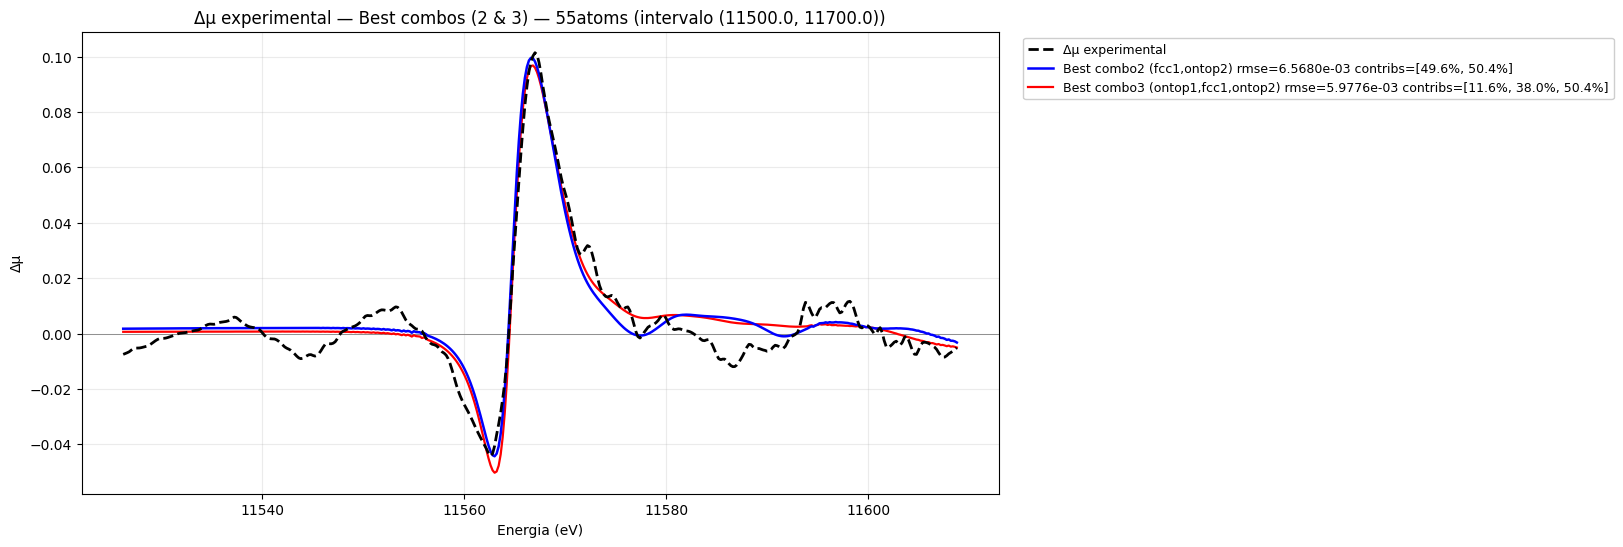

[55atoms] plot salvo: plots_final\delta_best_combos_55atoms.png
[116atoms] pontos = 414 | sítios = 10
[116atoms] Best combo2: sites=['ontop1', '4fold1'] rmse=7.7009e-03
    site=ontop1       coef=-9.032687e+00  contrib= 50.18%  signed=-50.18%
    site=4fold1       coef= 8.958116e+00  contrib= 49.82%  signed= 49.82%
[116atoms] Best combo3: sites=['bridge1', 'ontop3', 'ontop4'] rmse=4.9043e-03
    site=bridge1      coef=-5.432798e+00  contrib= 50.29%  signed=-50.29%
    site=ontop3       coef= 3.199521e+00  contrib= 30.06%  signed= 30.06%
    site=ontop4       coef= 2.117747e+00  contrib= 19.65%  signed= 19.65%


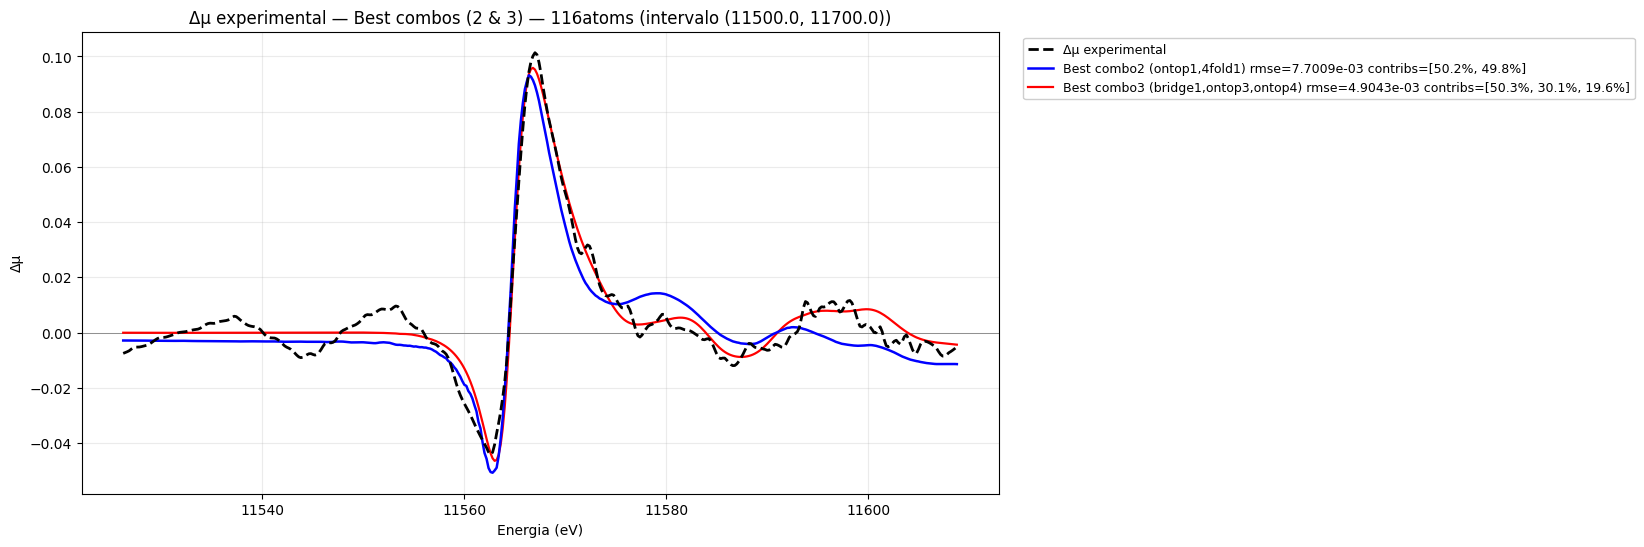

[116atoms] plot salvo: plots_final\delta_best_combos_116atoms.png
Pronto — plots gerados em: plots_final


In [93]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
delta_best_combos_plot_only.py (cores ajustadas)

Mesma lógica do seu script anterior; única mudança funcional: cores das curvas:
- experimental: preto
- best combo2: azul
- best combo3: vermelho
"""
import os
import glob
import itertools
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

# -------- CONFIG --------
NORM_DIR = "normalized"
PLOTS_DIR = "plots_final"
os.makedirs(PLOTS_DIR, exist_ok=True)

ENERGY_RANGE = (11500.0, 11700.0)   # definir None para usar todo o intervalo
TOP_N_COMBOS = 1000

# -------- Mapas de rótulos (ajuste se necessário) --------
site_labels_55 = {
    '00': 'pristina', '01': 'ontop', '02': 'bridge', '03': 'fcc',
    '04': 'hcp', '05': '4fold', '06': 'bridge', '07': 'ontop', '08': 'ontop'
}
site_labels_116 = {
    '00': 'pristina', '01': 'ontop', '02': 'bridge', '03': 'fcc',
    '04': 'bridge', '05': 'hcp', '06': '4fold', '07': 'ontop',
    '08': 'ontop', '09': 'bridge', '10': 'ontop'
}


# -------- utilitárias --------
def load_norm_file(fname):
    data = np.loadtxt(fname, comments="#")
    E = data[:, 0]
    final = data[:, -1]
    return E, final

def interp_to_ref(E_ref, E, mu):
    return np.interp(E_ref, E, mu)

def site_label(fname):
    base = os.path.basename(fname)
    if base.startswith("55_"):
        parts = base.split("_")
        if len(parts) >= 2:
            return site_labels_55.get(parts[1], base.replace("_norm.txt",""))
    if base.startswith("116_"):
        parts = base.split("_")
        if len(parts) >= 2:
            return site_labels_116.get(parts[1], base.replace("_norm.txt",""))
    return base.replace("_norm.txt","")

def rmse(a, b):
    return float(np.sqrt(np.mean((a - b)**2)))

def make_unique_names(names):
    """Converte ['ontop','bridge','ontop'] -> ['ontop1','bridge1','ontop2']"""
    counts = {}
    out = []
    for n in names:
        c = counts.get(n, 0) + 1
        counts[n] = c
        out.append(f"{n}{c}")
    return out

def choose_savgol_window(n, preferred=11, polyorder=3):
    """Escolhe um window seguro (ímpar, > polyorder, <= n). Retorna None se não for possível."""
    if n < 3:
        return None
    w = min(preferred, n)
    if w % 2 == 0:
        w -= 1
    if w <= polyorder:
        w = polyorder + 1
        if w % 2 == 0:
            w += 1
    if w > n:
        w = n if n % 2 == 1 else n - 1
    if w < 3 or w <= polyorder:
        return None
    return w

def smooth_signal(y, preferred_window=11, polyorder=3):
    n = len(y)
    w = choose_savgol_window(n, preferred_window, polyorder)
    if w is None:
        return y
    try:
        return savgol_filter(y, window_length=w, polyorder=polyorder)
    except Exception:
        return y

# -------- Ler arquivos --------
files = glob.glob(os.path.join(NORM_DIR, "*_norm.txt"))
files_55 = sorted([f for f in files if os.path.basename(f).startswith("55_")])
files_116 = sorted([f for f in files if os.path.basename(f).startswith("116_")])

# detectar experimentais e bulk (heurística)
exp_files = [f for f in files if ("XANES_Pt_Foil" in f) or ("XANES_Pt_MoS2" in f) or ("Foil" in f and "MoS2" in f)]
if len(exp_files) < 2:
    exp_files = [f for f in files if "Foil" in os.path.basename(f) or "160" in os.path.basename(f)]
if len(exp_files) < 2:
    raise RuntimeError("Arquivos experimentais não encontrados em 'normalized'. Verifique nomes (Foil / 160 / XANES_Pt_Foil...).")
bulk_candidates = [f for f in files if "Pt_bulk" in f or "bulk" in os.path.basename(f).lower()]
if not bulk_candidates:
    raise RuntimeError("Arquivo Pt_bulk não encontrado em 'normalized'.")
bulk_file = bulk_candidates[0]

# escolher dois experimentais (foil e outro)
exp_foil = None
exp_other = None
for f in exp_files:
    b = os.path.basename(f)
    if "Foil" in b or "foil" in b:
        exp_foil = f
    if "160" in b or "MoS2" in b or "moS2" in b:
        exp_other = f
if exp_foil is None or exp_other is None:
    exp_foil = exp_files[0]
    exp_other = exp_files[1]

E_exp_full, mu_exp_foil = load_norm_file(exp_foil)
_, mu_exp_other = load_norm_file(exp_other)
delta_exp_full = mu_exp_foil - mu_exp_other

E_bulk, mu_bulk = load_norm_file(bulk_file)
mu_bulk_interp_full = interp_to_ref(E_exp_full, E_bulk, mu_bulk)

# -------- Construir Δµ de cada sítio (excluindo pristina '00') --------
def build_delta_matrix_for_files(files_list, E_ref, mu_bulk_interp_ref):
    curves, names = [], []
    for f in files_list:
        parts = os.path.basename(f).split("_")
        if len(parts) >= 2 and parts[1] == "00":
            continue
        E, mu = load_norm_file(f)
        mu_interp = interp_to_ref(E_ref, E, mu)
        delta = mu_interp - mu_bulk_interp_ref
        curves.append(delta)
        names.append(site_label(f))
    if len(curves) == 0:
        return np.zeros((len(E_ref), 0)), []
    unique = make_unique_names(names)
    return np.array(curves).T, unique  # shape (n_points, n_sites)

delta_55_full, names_55 = build_delta_matrix_for_files(files_55, E_exp_full, mu_bulk_interp_full)
delta_116_full, names_116 = build_delta_matrix_for_files(files_116, E_exp_full, mu_bulk_interp_full)

# -------- Função para recortar por energia --------
def apply_energy_cut(E_full, y_full, X_full, energy_range):
    if energy_range is None:
        return E_full, y_full, X_full
    emin, emax = energy_range
    mask = (E_full >= emin) & (E_full <= emax)
    if mask.sum() == 0:
        raise RuntimeError(f"Nenhum ponto dentro do intervalo {energy_range}.")
    Xcut = X_full[mask, :] if X_full.size else X_full
    return E_full[mask], y_full[mask], Xcut

# -------- Função para encontrar melhores combinações (size = 2 ou 3) --------
def best_combinations_by_rmse(X, y, names, comb_size=2, top_n=10):
    """
    Agora retorna, para cada combinação:
      - indices, sites, lsq_coefs, lsq_rmse
      - lsq_contrib_percent : porcentagem (soma=100) baseada em ||coef * Xcol||_2
      - lsq_contrib_signed_percent : mesma porcentagem mas com sinal do coef (pode ter +/−)
    """
    if X.size == 0 or X.shape[1] < comb_size:
        return []
    n_sites = X.shape[1]
    combos = list(itertools.combinations(range(n_sites), comb_size))
    out = []
    for comb in combos:
        cols = list(comb)
        Xsub = X[:, cols]
        sol, *_ = np.linalg.lstsq(Xsub, y, rcond=None)
        coefs = sol
        ypred = Xsub.dot(sol)
        lsq_rmse = rmse(y, ypred)

        # --- calcular contribuições percentuais de cada componente ---
        contrib_norms = np.array([np.linalg.norm(Xsub[:, i] * coefs[i]) for i in range(len(coefs))], dtype=float)
        total_norm = contrib_norms.sum()
        if total_norm == 0:
            mag = np.abs(coefs)
            if mag.sum() == 0:
                perc = np.zeros_like(mag)
            else:
                perc = 100.0 * mag / mag.sum()
            signed_perc = perc * np.sign(coefs)
        else:
            perc = 100.0 * contrib_norms / total_norm
            signed_perc = perc * np.sign(coefs)

        out.append({
            "indices": cols,
            "sites": [names[i] for i in cols],
            "lsq_coefs": np.asarray(coefs),
            "lsq_rmse": float(lsq_rmse),
            "lsq_contrib_percent": perc.tolist(),
            "lsq_contrib_signed_percent": signed_perc.tolist()
        })
    out_sorted = sorted(out, key=lambda x: x["lsq_rmse"])
    return out_sorted[:min(top_n, len(out_sorted))]

# -------- Função que plota somente experimental (tracejada) + best combo2 e best combo3 (sólidas) --------
def plot_best_combos(E_full, delta_exp_full, delta_matrix_full, names, set_label, smooth_combos=False):
    E, y, X = apply_energy_cut(E_full, delta_exp_full, delta_matrix_full, ENERGY_RANGE)
    print(f"[{set_label}] pontos = {len(E)} | sítios = {len(names)}")

    combos_2 = best_combinations_by_rmse(X, y, names, comb_size=2, top_n=TOP_N_COMBOS)
    combos_3 = best_combinations_by_rmse(X, y, names, comb_size=3, top_n=TOP_N_COMBOS)

    # --- figura mais larga para evitar compressão pelas legendas externas ---
    fig, ax = plt.subplots(figsize=(14, 6))

    # experimental: TRACEJADA (preto)
    ax.plot(E, y, linestyle='--', linewidth=2.0, label="Δµ experimental", color='black', zorder=10)

    # best combo2: LINHA SÓLIDA (azul)
    if len(combos_2) > 0:
        best2 = combos_2[0]
        cols2 = best2["indices"]
        try:
            y_best2 = X[:, cols2].dot(best2["lsq_coefs"])
            if smooth_combos:
                y_best2 = smooth_signal(y_best2, preferred_window=15, polyorder=3)
            perc_str = ", ".join([f"{p:.1f}%" for p in best2["lsq_contrib_percent"]])
            ax.plot(E, y_best2, linestyle='-', linewidth=1.8,
                     label=f"Best combo2 ({','.join(best2['sites'])}) rmse={best2['lsq_rmse']:.4e} contribs=[{perc_str}]",
                     color='blue', zorder=9)
            print(f"[{set_label}] Best combo2: sites={best2['sites']} rmse={best2['lsq_rmse']:.4e}")
            for s, c, p, sp in zip(best2['sites'], best2['lsq_coefs'], best2['lsq_contrib_percent'], best2['lsq_contrib_signed_percent']):
                print(f"    site={s:12s} coef={c: .6e}  contrib={p:6.2f}%  signed={sp:6.2f}%")
        except Exception as e:
            print(f"[{set_label}] erro ao construir best combo2: {e}")
    else:
        print(f"[{set_label}] sem combos de 2 sítios.")

    # best combo3: LINHA SÓLIDA (vermelho)
    if len(combos_3) > 0:
        best3 = combos_3[0]
        cols3 = best3["indices"]
        try:
            y_best3 = X[:, cols3].dot(best3["lsq_coefs"])
            if smooth_combos:
                y_best3 = smooth_signal(y_best3, preferred_window=15, polyorder=3)
            perc_str3 = ", ".join([f"{p:.1f}%" for p in best3["lsq_contrib_percent"]])
            ax.plot(E, y_best3, linestyle='-', linewidth=1.6,
                     label=f"Best combo3 ({','.join(best3['sites'])}) rmse={best3['lsq_rmse']:.4e} contribs=[{perc_str3}]",
                     color='red', zorder=8)
            print(f"[{set_label}] Best combo3: sites={best3['sites']} rmse={best3['lsq_rmse']:.4e}")
            for s, c, p, sp in zip(best3['sites'], best3['lsq_coefs'], best3['lsq_contrib_percent'], best3['lsq_contrib_signed_percent']):
                print(f"    site={s:12s} coef={c: .6e}  contrib={p:6.2f}%  signed={sp:6.2f}%")
        except Exception as e:
            print(f"[{set_label}] erro ao construir best combo3: {e}")
    else:
        print(f"[{set_label}] sem combos de 3 sítios.")

    ax.axhline(0, color='gray', lw=0.6)
    ax.set_xlabel("Energia (eV)")
    ax.set_ylabel("Δµ")
    ax.set_title(f"Δµ experimental — Best combos (2 & 3) — {set_label} (intervalo {ENERGY_RANGE})")

    # legenda fora do gráfico (à direita) sem encolher demais a área de plot
    legend = ax.legend(fontsize=9, loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=True)
    legend.get_frame().set_alpha(0.95)

    ax.grid(alpha=0.25)

    # reservar espaço para a legenda externa (ajuste a fração direita conforme necessário)
    fig.subplots_adjust(right=0.78)

    figfile = os.path.join(PLOTS_DIR, f"delta_best_combos_{set_label}.png")
    fig.savefig(figfile, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"[{set_label}] plot salvo: {figfile}")

# -------- Executar plots: 55 (sem suavizar) e 116 (suavizar combos) --------
plot_best_combos(E_exp_full, delta_exp_full, delta_55_full, names_55, set_label="55atoms", smooth_combos=False)
plot_best_combos(E_exp_full, delta_exp_full, delta_116_full, names_116, set_label="116atoms", smooth_combos=True)

print("Pronto — plots gerados em:", PLOTS_DIR)


[55atoms] pontos = 285 | sítios = 8
[55atoms] Best combo2: sites=['fcc1', 'ontop2'] rmse=8.2909e-03
    site=fcc1         coef= 2.976612e+00  contrib= 49.95%  signed= 49.95%
    site=ontop2       coef=-2.898809e+00  contrib= 50.05%  signed=-50.05%
[55atoms] Best combo3: sites=['ontop1', 'fcc1', 'ontop2'] rmse=6.2658e-03
    site=ontop1       coef= 8.251714e-01  contrib= 12.51%  signed= 12.51%
    site=fcc1         coef= 2.921076e+00  contrib= 37.47%  signed= 37.47%
    site=ontop2       coef=-3.789509e+00  contrib= 50.01%  signed=-50.01%


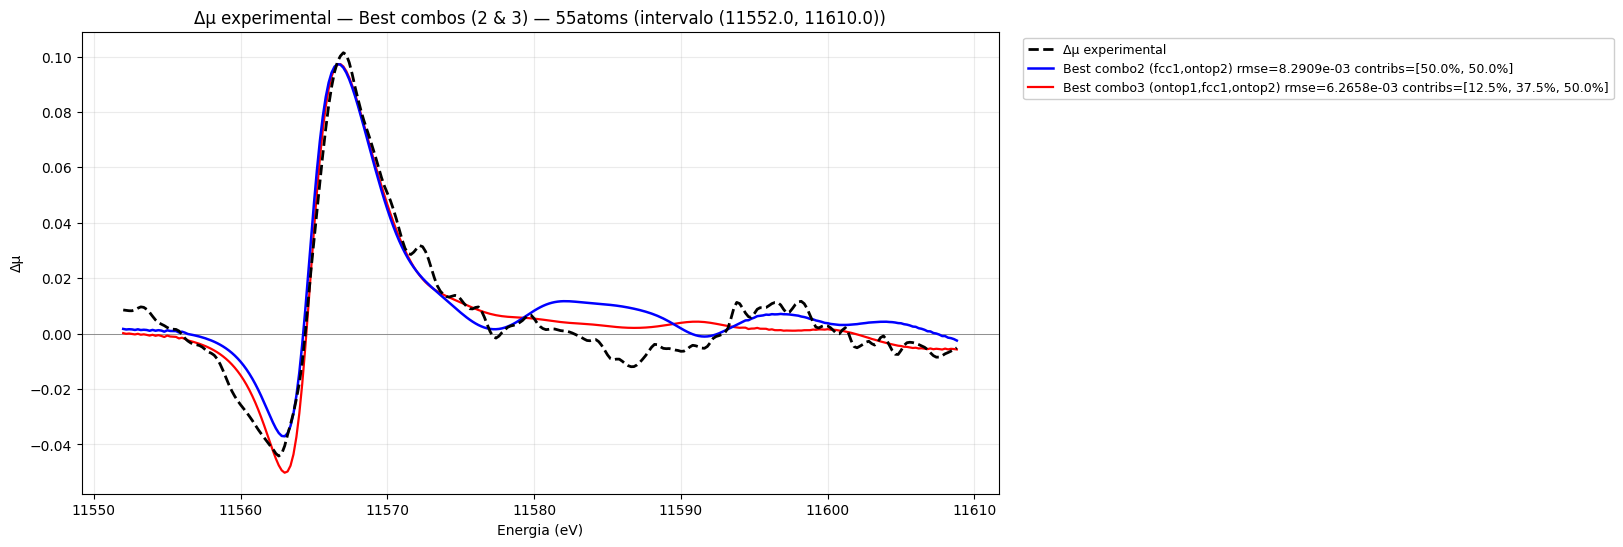

[55atoms] plot salvo: plots_final\delta_best_combos_55atoms.png
[116atoms] pontos = 285 | sítios = 10
[116atoms] Best combo2: sites=['bridge1', '4fold1'] rmse=8.8645e-03
    site=bridge1      coef=-9.548913e+00  contrib= 49.95%  signed=-49.95%
    site=4fold1       coef= 9.424854e+00  contrib= 50.05%  signed= 50.05%
[116atoms] Best combo3: sites=['bridge1', 'ontop2', 'ontop4'] rmse=6.8341e-03
    site=bridge1      coef=-7.115984e+00  contrib= 49.79%  signed=-49.79%
    site=ontop2       coef= 3.697435e+00  contrib= 26.62%  signed= 26.62%
    site=ontop4       coef= 3.131491e+00  contrib= 23.59%  signed= 23.59%


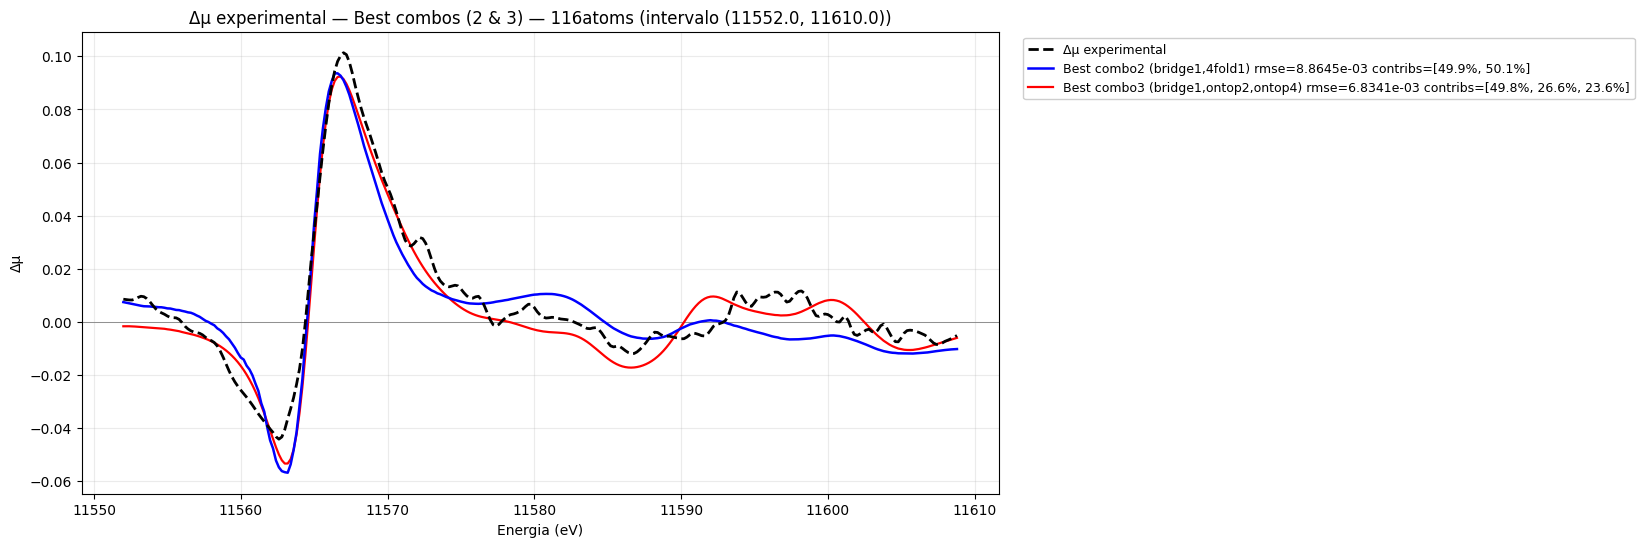

[116atoms] plot salvo: plots_final\delta_best_combos_116atoms.png
Pronto — plots gerados em: plots_final


In [4]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
delta_best_combos_plot_only.py (cores ajustadas)

Mesma lógica do seu script anterior; única mudança funcional: cores das curvas:
- experimental: preto
- best combo2: azul
- best combo3: vermelho
"""
import os
import glob
import itertools
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

# -------- CONFIG --------
NORM_DIR = "normalized"
PLOTS_DIR = "plots_final"
os.makedirs(PLOTS_DIR, exist_ok=True)

ENERGY_RANGE = (11552.0, 11610.0)   # definir None para usar todo o intervalo
TOP_N_COMBOS = 1000

# -------- Mapas de rótulos (ajuste se necessário) --------
site_labels_55 = {
    '00': 'pristina', '01': 'ontop', '02': 'bridge', '03': 'fcc',
    '04': 'hcp', '05': '4fold', '06': 'bridge', '07': 'ontop', '08': 'ontop'
}
site_labels_116 = {
    '00': 'pristina', '01': 'ontop', '02': 'bridge', '03': 'fcc',
    '04': 'bridge', '05': 'hcp', '06': '4fold', '07': 'ontop',
    '08': 'ontop', '09': 'bridge', '10': 'ontop'
}


# -------- utilitárias --------
def load_norm_file(fname):
    data = np.loadtxt(fname, comments="#")
    E = data[:, 0]
    final = data[:, -1]
    return E, final

def interp_to_ref(E_ref, E, mu):
    return np.interp(E_ref, E, mu)

def site_label(fname):
    base = os.path.basename(fname)
    if base.startswith("55_"):
        parts = base.split("_")
        if len(parts) >= 2:
            return site_labels_55.get(parts[1], base.replace("_norm.txt",""))
    if base.startswith("116_"):
        parts = base.split("_")
        if len(parts) >= 2:
            return site_labels_116.get(parts[1], base.replace("_norm.txt",""))
    return base.replace("_norm.txt","")

def rmse(a, b):
    return float(np.sqrt(np.mean((a - b)**2)))

def make_unique_names(names):
    """Converte ['ontop','bridge','ontop'] -> ['ontop1','bridge1','ontop2']"""
    counts = {}
    out = []
    for n in names:
        c = counts.get(n, 0) + 1
        counts[n] = c
        out.append(f"{n}{c}")
    return out

def choose_savgol_window(n, preferred=11, polyorder=3):
    """Escolhe um window seguro (ímpar, > polyorder, <= n). Retorna None se não for possível."""
    if n < 3:
        return None
    w = min(preferred, n)
    if w % 2 == 0:
        w -= 1
    if w <= polyorder:
        w = polyorder + 1
        if w % 2 == 0:
            w += 1
    if w > n:
        w = n if n % 2 == 1 else n - 1
    if w < 3 or w <= polyorder:
        return None
    return w

def smooth_signal(y, preferred_window=11, polyorder=3):
    n = len(y)
    w = choose_savgol_window(n, preferred_window, polyorder)
    if w is None:
        return y
    try:
        return savgol_filter(y, window_length=w, polyorder=polyorder)
    except Exception:
        return y

# -------- Ler arquivos --------
files = glob.glob(os.path.join(NORM_DIR, "*_norm.txt"))
files_55 = sorted([f for f in files if os.path.basename(f).startswith("55_")])
files_116 = sorted([f for f in files if os.path.basename(f).startswith("116_")])

# detectar experimentais e bulk (heurística)
exp_files = [f for f in files if ("XANES_Pt_Foil" in f) or ("XANES_Pt_MoS2" in f) or ("Foil" in f and "MoS2" in f)]
if len(exp_files) < 2:
    exp_files = [f for f in files if "Foil" in os.path.basename(f) or "160" in os.path.basename(f)]
if len(exp_files) < 2:
    raise RuntimeError("Arquivos experimentais não encontrados em 'normalized'. Verifique nomes (Foil / 160 / XANES_Pt_Foil...).")
bulk_candidates = [f for f in files if "Pt_bulk" in f or "bulk" in os.path.basename(f).lower()]
if not bulk_candidates:
    raise RuntimeError("Arquivo Pt_bulk não encontrado em 'normalized'.")
bulk_file = bulk_candidates[0]

# escolher dois experimentais (foil e outro)
exp_foil = None
exp_other = None
for f in exp_files:
    b = os.path.basename(f)
    if "Foil" in b or "foil" in b:
        exp_foil = f
    if "160" in b or "MoS2" in b or "moS2" in b:
        exp_other = f
if exp_foil is None or exp_other is None:
    exp_foil = exp_files[0]
    exp_other = exp_files[1]

E_exp_full, mu_exp_foil = load_norm_file(exp_foil)
_, mu_exp_other = load_norm_file(exp_other)
delta_exp_full = mu_exp_foil - mu_exp_other

E_bulk, mu_bulk = load_norm_file(bulk_file)
mu_bulk_interp_full = interp_to_ref(E_exp_full, E_bulk, mu_bulk)

# -------- Construir Δµ de cada sítio (excluindo pristina '00') --------
def build_delta_matrix_for_files(files_list, E_ref, mu_bulk_interp_ref):
    curves, names = [], []
    for f in files_list:
        parts = os.path.basename(f).split("_")
        if len(parts) >= 2 and parts[1] == "00":
            continue
        E, mu = load_norm_file(f)
        mu_interp = interp_to_ref(E_ref, E, mu)
        delta = mu_interp - mu_bulk_interp_ref
        curves.append(delta)
        names.append(site_label(f))
    if len(curves) == 0:
        return np.zeros((len(E_ref), 0)), []
    unique = make_unique_names(names)
    return np.array(curves).T, unique  # shape (n_points, n_sites)

delta_55_full, names_55 = build_delta_matrix_for_files(files_55, E_exp_full, mu_bulk_interp_full)
delta_116_full, names_116 = build_delta_matrix_for_files(files_116, E_exp_full, mu_bulk_interp_full)

# -------- Função para recortar por energia --------
def apply_energy_cut(E_full, y_full, X_full, energy_range):
    if energy_range is None:
        return E_full, y_full, X_full
    emin, emax = energy_range
    mask = (E_full >= emin) & (E_full <= emax)
    if mask.sum() == 0:
        raise RuntimeError(f"Nenhum ponto dentro do intervalo {energy_range}.")
    Xcut = X_full[mask, :] if X_full.size else X_full
    return E_full[mask], y_full[mask], Xcut

# -------- Função para encontrar melhores combinações (size = 2 ou 3) --------
def best_combinations_by_rmse(X, y, names, comb_size=2, top_n=10):
    """
    Agora retorna, para cada combinação:
      - indices, sites, lsq_coefs, lsq_rmse
      - lsq_contrib_percent : porcentagem (soma=100) baseada em ||coef * Xcol||_2
      - lsq_contrib_signed_percent : mesma porcentagem mas com sinal do coef (pode ter +/−)
    """
    if X.size == 0 or X.shape[1] < comb_size:
        return []
    n_sites = X.shape[1]
    combos = list(itertools.combinations(range(n_sites), comb_size))
    out = []
    for comb in combos:
        cols = list(comb)
        Xsub = X[:, cols]
        sol, *_ = np.linalg.lstsq(Xsub, y, rcond=None)
        coefs = sol
        ypred = Xsub.dot(sol)
        lsq_rmse = rmse(y, ypred)

        # --- calcular contribuições percentuais de cada componente ---
        contrib_norms = np.array([np.linalg.norm(Xsub[:, i] * coefs[i]) for i in range(len(coefs))], dtype=float)
        total_norm = contrib_norms.sum()
        if total_norm == 0:
            mag = np.abs(coefs)
            if mag.sum() == 0:
                perc = np.zeros_like(mag)
            else:
                perc = 100.0 * mag / mag.sum()
            signed_perc = perc * np.sign(coefs)
        else:
            perc = 100.0 * contrib_norms / total_norm
            signed_perc = perc * np.sign(coefs)

        out.append({
            "indices": cols,
            "sites": [names[i] for i in cols],
            "lsq_coefs": np.asarray(coefs),
            "lsq_rmse": float(lsq_rmse),
            "lsq_contrib_percent": perc.tolist(),
            "lsq_contrib_signed_percent": signed_perc.tolist()
        })
    out_sorted = sorted(out, key=lambda x: x["lsq_rmse"])
    return out_sorted[:min(top_n, len(out_sorted))]

# -------- Função que plota somente experimental (tracejada) + best combo2 e best combo3 (sólidas) --------
def plot_best_combos(E_full, delta_exp_full, delta_matrix_full, names, set_label, smooth_combos=False):
    E, y, X = apply_energy_cut(E_full, delta_exp_full, delta_matrix_full, ENERGY_RANGE)
    print(f"[{set_label}] pontos = {len(E)} | sítios = {len(names)}")

    combos_2 = best_combinations_by_rmse(X, y, names, comb_size=2, top_n=TOP_N_COMBOS)
    combos_3 = best_combinations_by_rmse(X, y, names, comb_size=3, top_n=TOP_N_COMBOS)

    # --- figura mais larga para evitar compressão pelas legendas externas ---
    fig, ax = plt.subplots(figsize=(14, 6))

    # experimental: TRACEJADA (preto)
    ax.plot(E, y, linestyle='--', linewidth=2.0, label="Δµ experimental", color='black', zorder=10)

    # best combo2: LINHA SÓLIDA (azul)
    if len(combos_2) > 0:
        best2 = combos_2[0]
        cols2 = best2["indices"]
        try:
            y_best2 = X[:, cols2].dot(best2["lsq_coefs"])
            if smooth_combos:
                y_best2 = smooth_signal(y_best2, preferred_window=15, polyorder=3)
            perc_str = ", ".join([f"{p:.1f}%" for p in best2["lsq_contrib_percent"]])
            ax.plot(E, y_best2, linestyle='-', linewidth=1.8,
                     label=f"Best combo2 ({','.join(best2['sites'])}) rmse={best2['lsq_rmse']:.4e} contribs=[{perc_str}]",
                     color='blue', zorder=9)
            print(f"[{set_label}] Best combo2: sites={best2['sites']} rmse={best2['lsq_rmse']:.4e}")
            for s, c, p, sp in zip(best2['sites'], best2['lsq_coefs'], best2['lsq_contrib_percent'], best2['lsq_contrib_signed_percent']):
                print(f"    site={s:12s} coef={c: .6e}  contrib={p:6.2f}%  signed={sp:6.2f}%")
        except Exception as e:
            print(f"[{set_label}] erro ao construir best combo2: {e}")
    else:
        print(f"[{set_label}] sem combos de 2 sítios.")

    # best combo3: LINHA SÓLIDA (vermelho)
    if len(combos_3) > 0:
        best3 = combos_3[0]
        cols3 = best3["indices"]
        try:
            y_best3 = X[:, cols3].dot(best3["lsq_coefs"])
            if smooth_combos:
                y_best3 = smooth_signal(y_best3, preferred_window=15, polyorder=3)
            perc_str3 = ", ".join([f"{p:.1f}%" for p in best3["lsq_contrib_percent"]])
            ax.plot(E, y_best3, linestyle='-', linewidth=1.6,
                     label=f"Best combo3 ({','.join(best3['sites'])}) rmse={best3['lsq_rmse']:.4e} contribs=[{perc_str3}]",
                     color='red', zorder=8)
            print(f"[{set_label}] Best combo3: sites={best3['sites']} rmse={best3['lsq_rmse']:.4e}")
            for s, c, p, sp in zip(best3['sites'], best3['lsq_coefs'], best3['lsq_contrib_percent'], best3['lsq_contrib_signed_percent']):
                print(f"    site={s:12s} coef={c: .6e}  contrib={p:6.2f}%  signed={sp:6.2f}%")
        except Exception as e:
            print(f"[{set_label}] erro ao construir best combo3: {e}")
    else:
        print(f"[{set_label}] sem combos de 3 sítios.")

    ax.axhline(0, color='gray', lw=0.6)
    ax.set_xlabel("Energia (eV)")
    ax.set_ylabel("Δµ")
    ax.set_title(f"Δµ experimental — Best combos (2 & 3) — {set_label} (intervalo {ENERGY_RANGE})")

    # legenda fora do gráfico (à direita) sem encolher demais a área de plot
    legend = ax.legend(fontsize=9, loc='upper left', bbox_to_anchor=(1.02, 1.0), frameon=True)
    legend.get_frame().set_alpha(0.95)

    ax.grid(alpha=0.25)

    # reservar espaço para a legenda externa (ajuste a fração direita conforme necessário)
    fig.subplots_adjust(right=0.78)

    figfile = os.path.join(PLOTS_DIR, f"delta_best_combos_{set_label}.png")
    fig.savefig(figfile, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"[{set_label}] plot salvo: {figfile}")

# -------- Executar plots: 55 (sem suavizar) e 116 (suavizar combos) --------
plot_best_combos(E_exp_full, delta_exp_full, delta_55_full, names_55, set_label="55atoms", smooth_combos=False)
plot_best_combos(E_exp_full, delta_exp_full, delta_116_full, names_116, set_label="116atoms", smooth_combos=True)

print("Pronto — plots gerados em:", PLOTS_DIR)


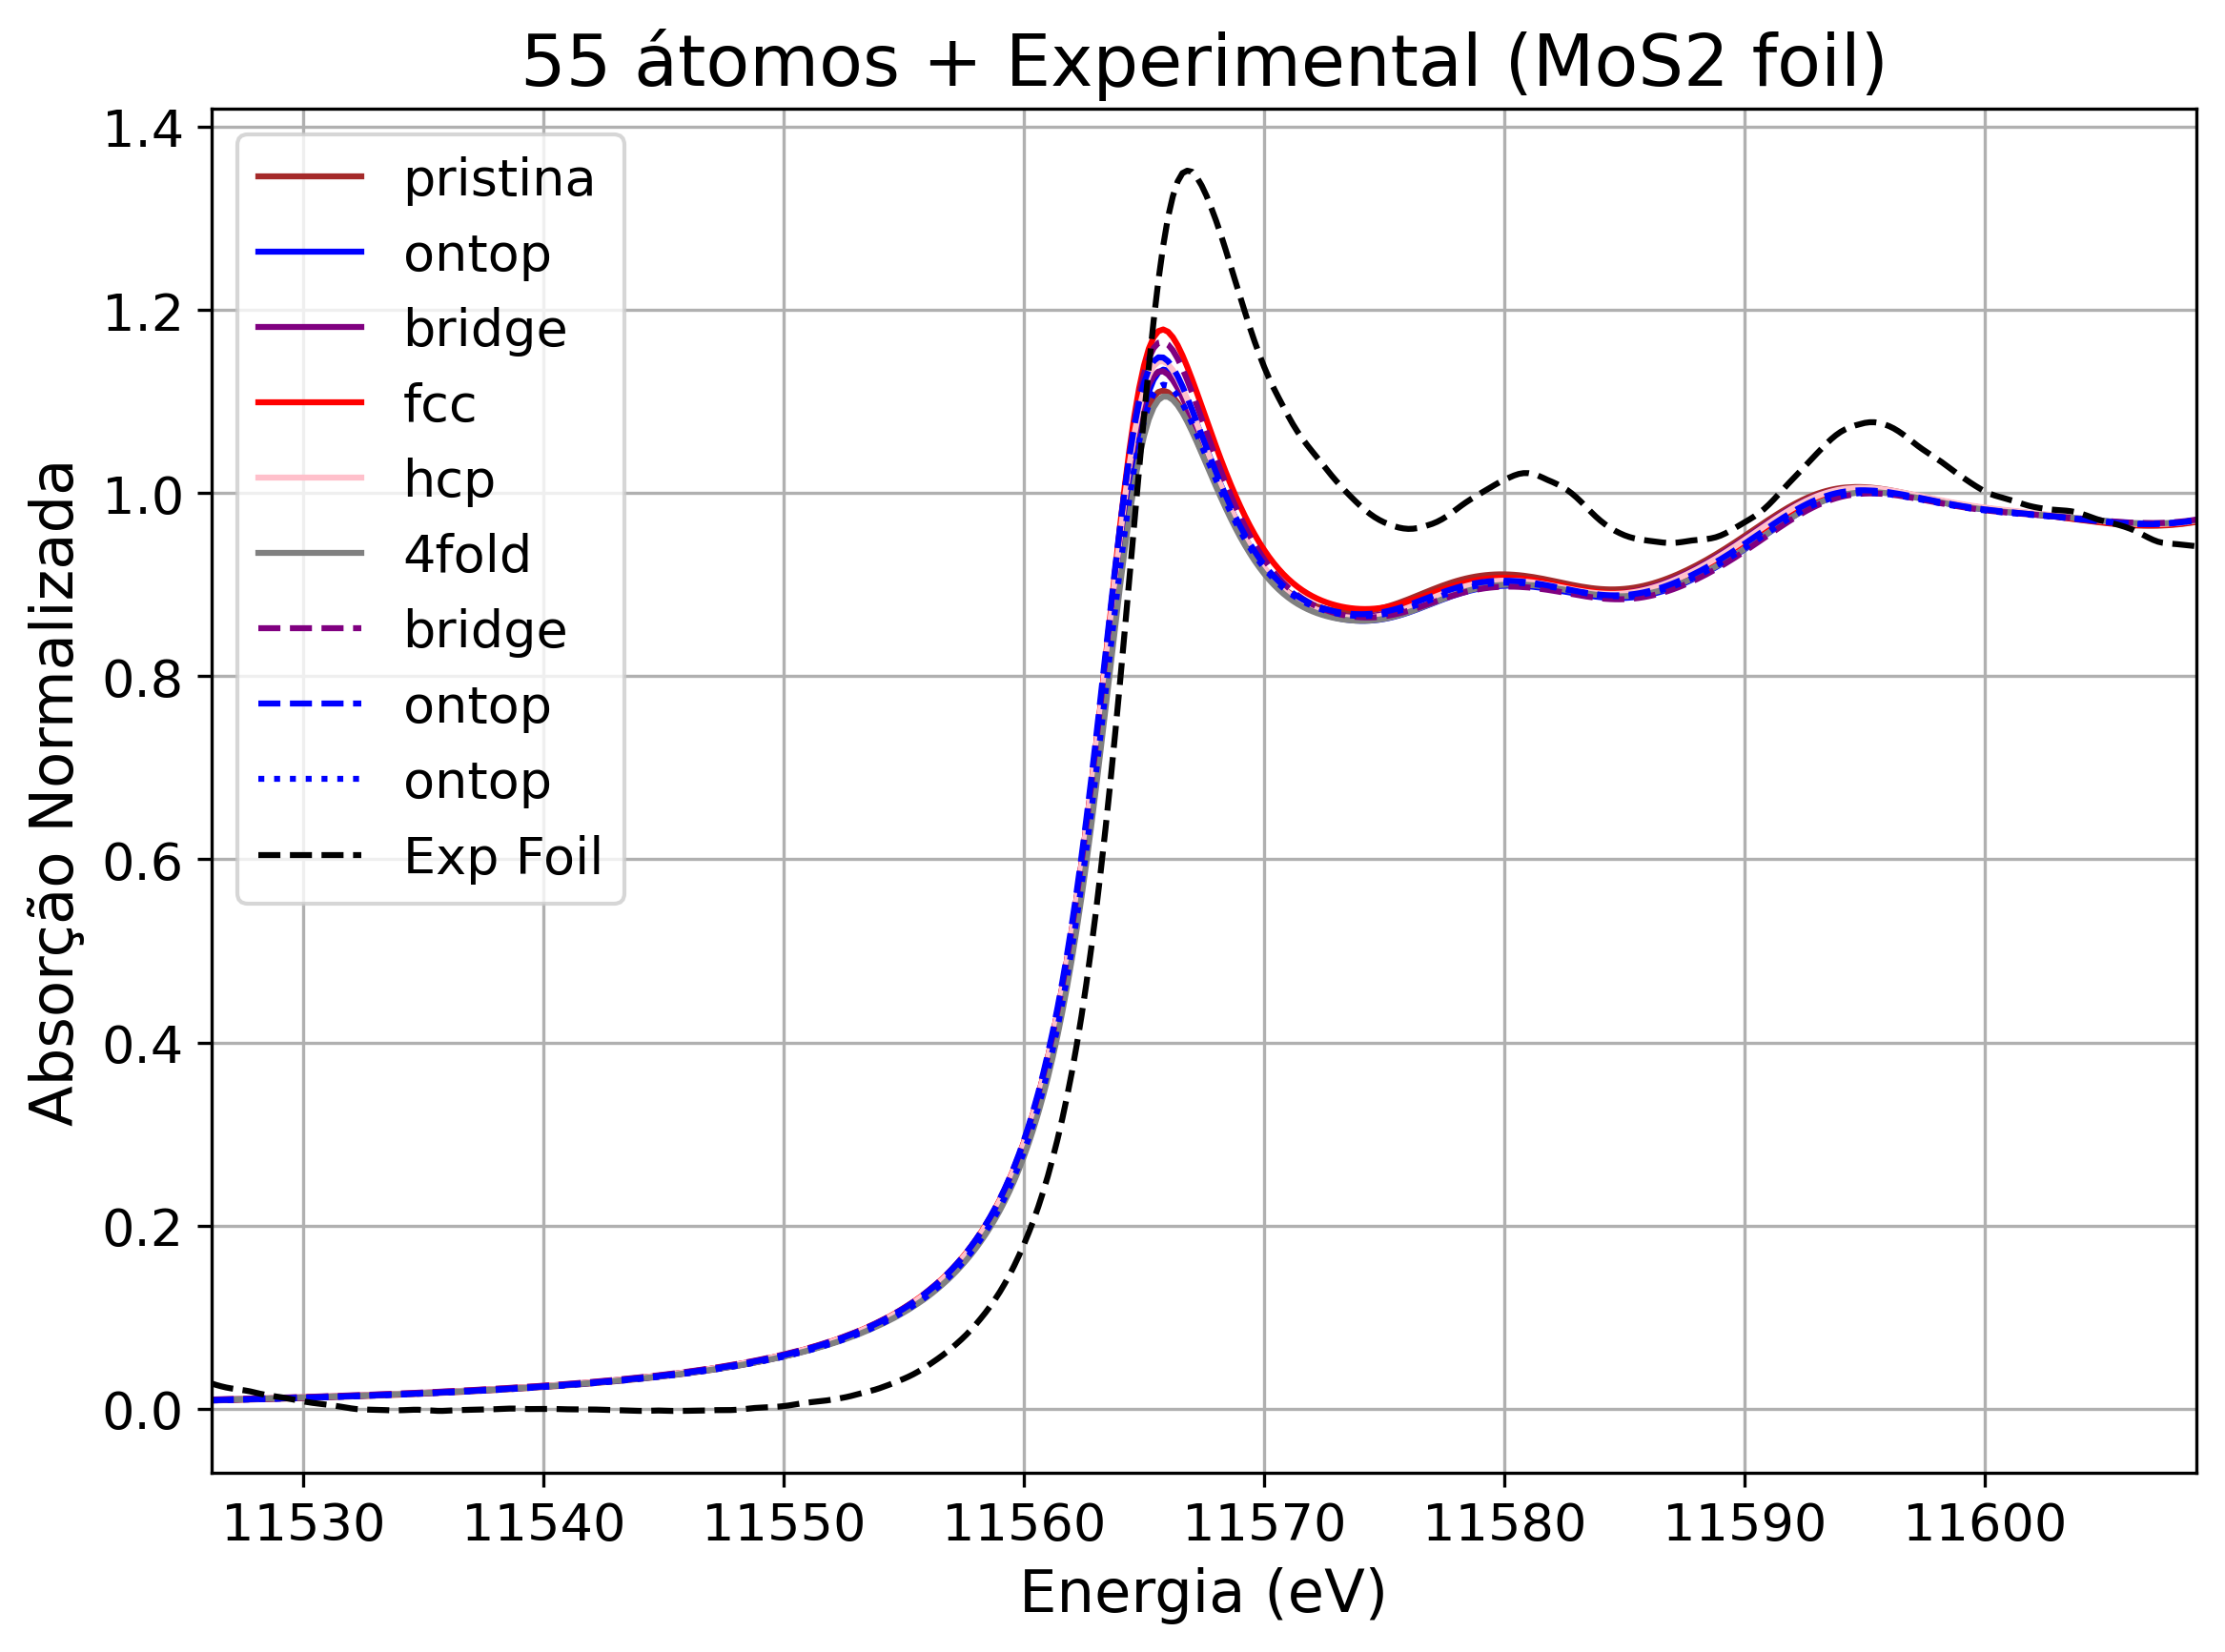

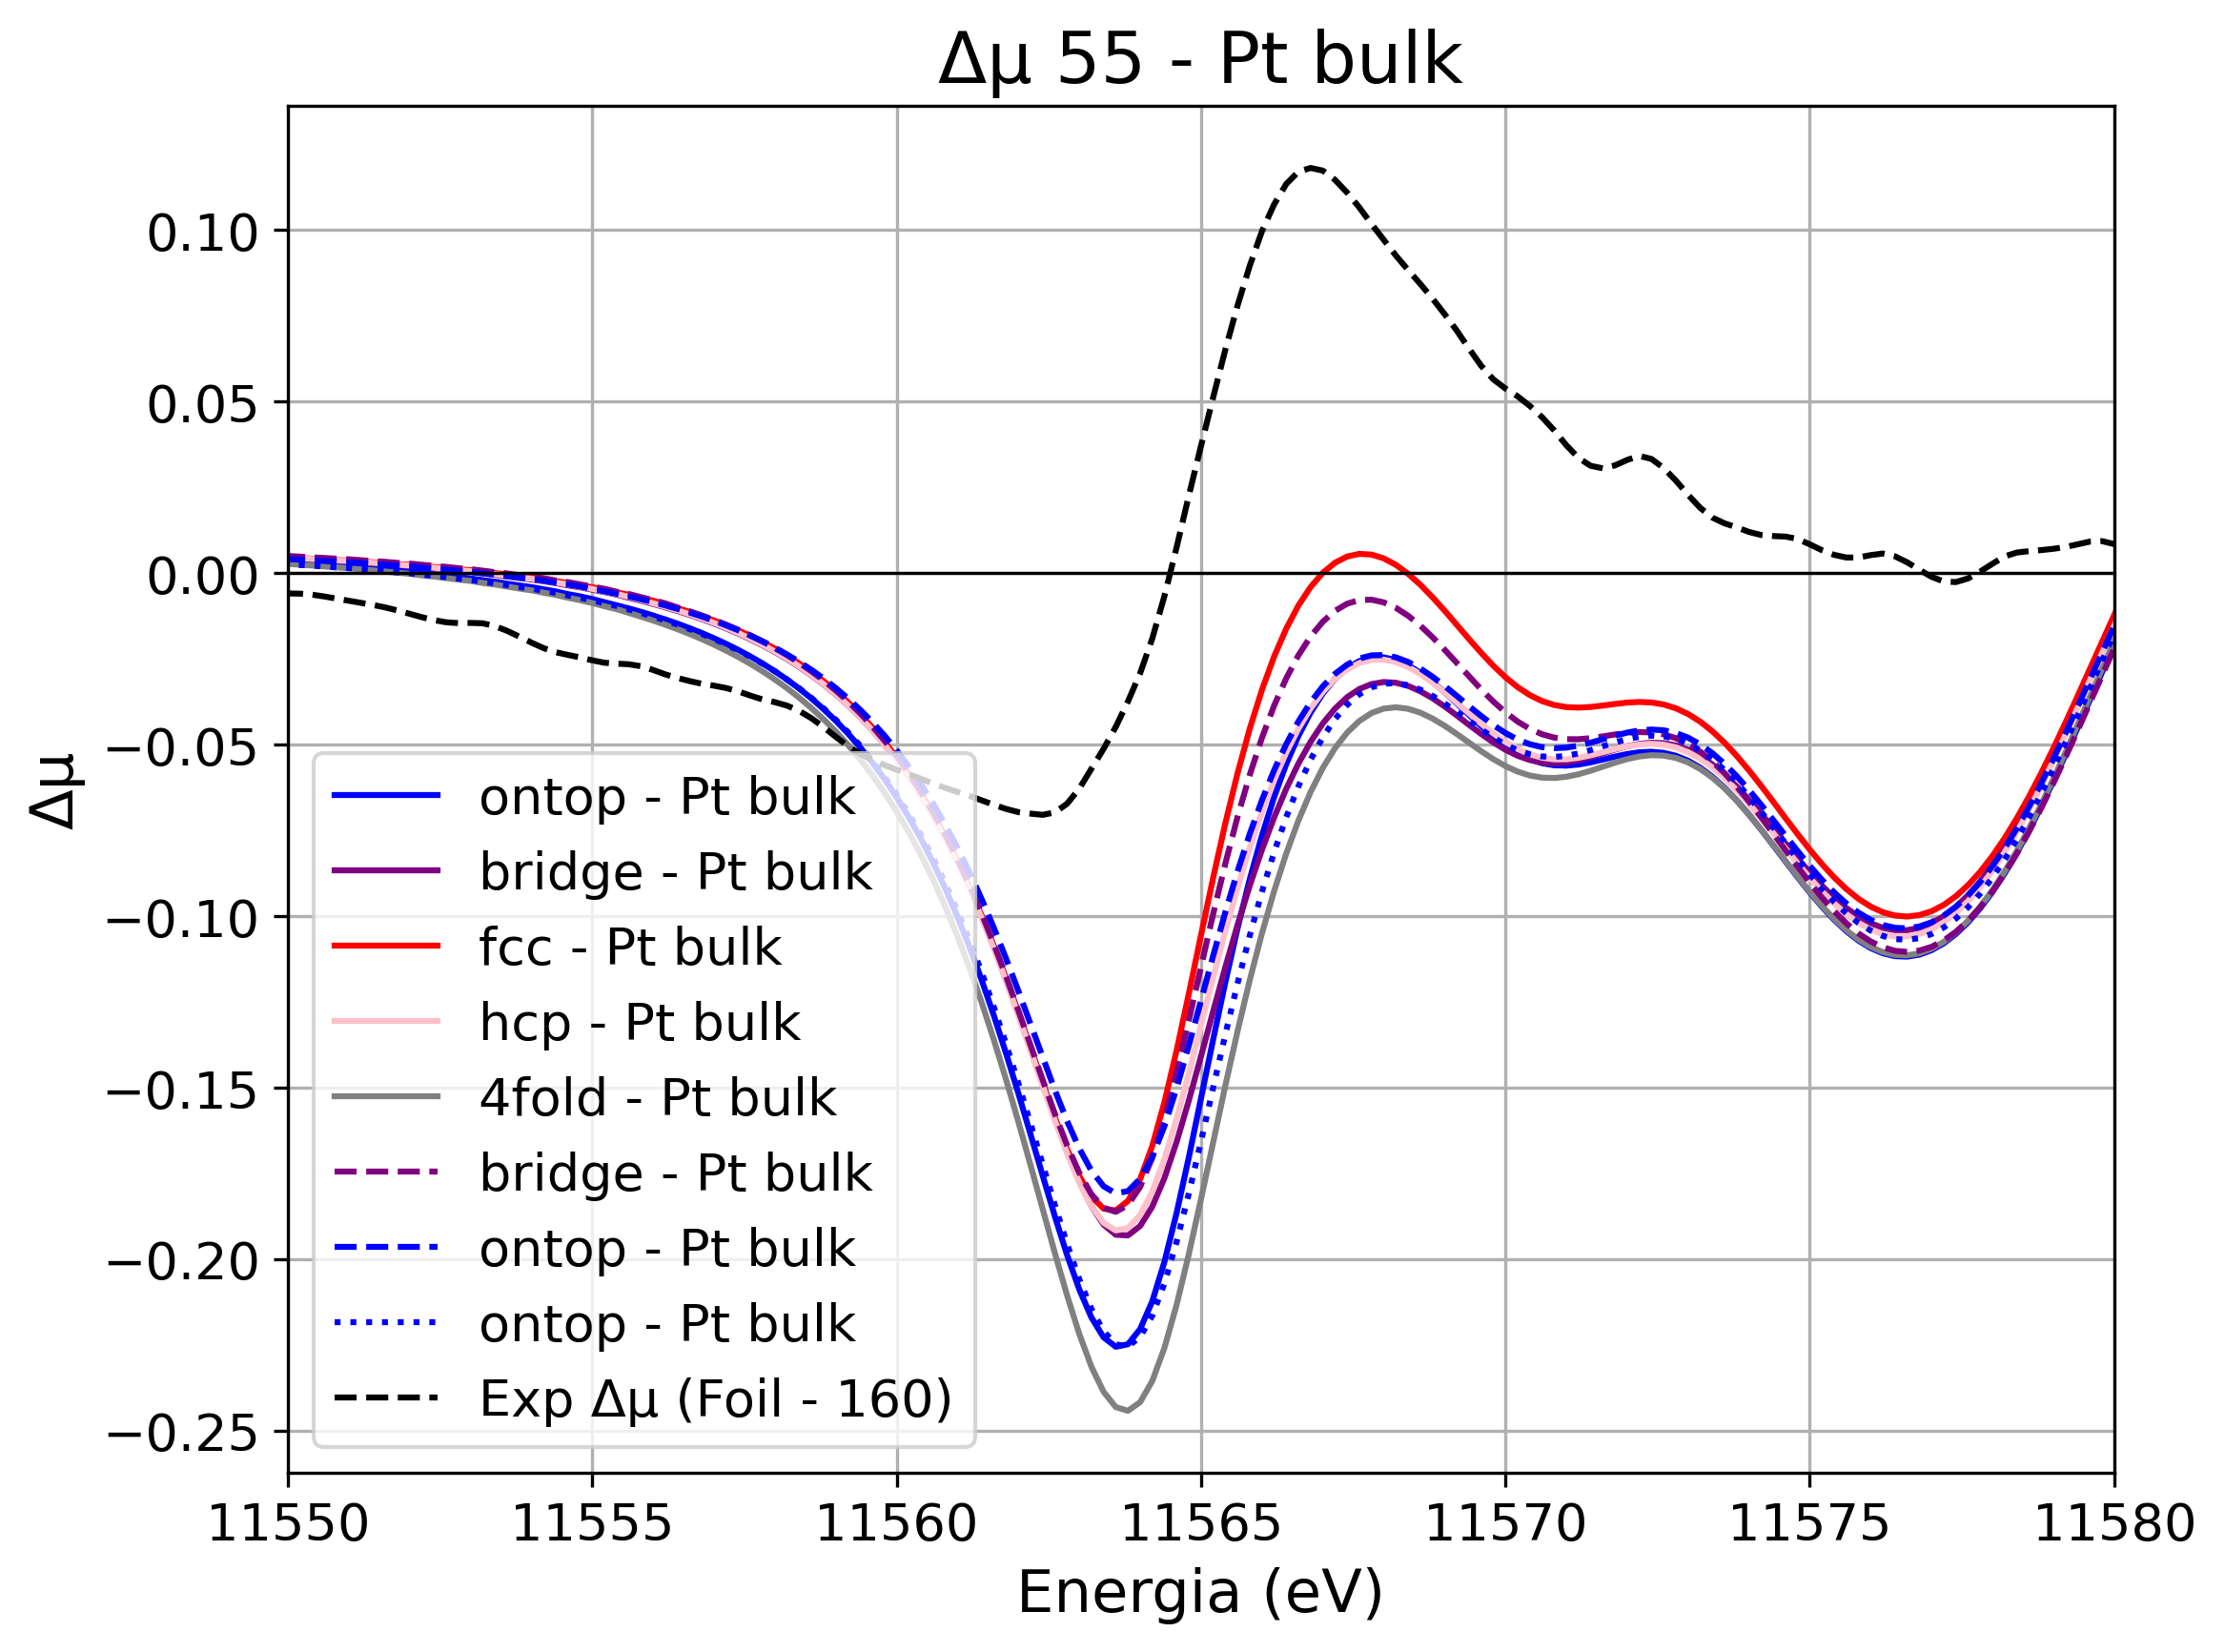

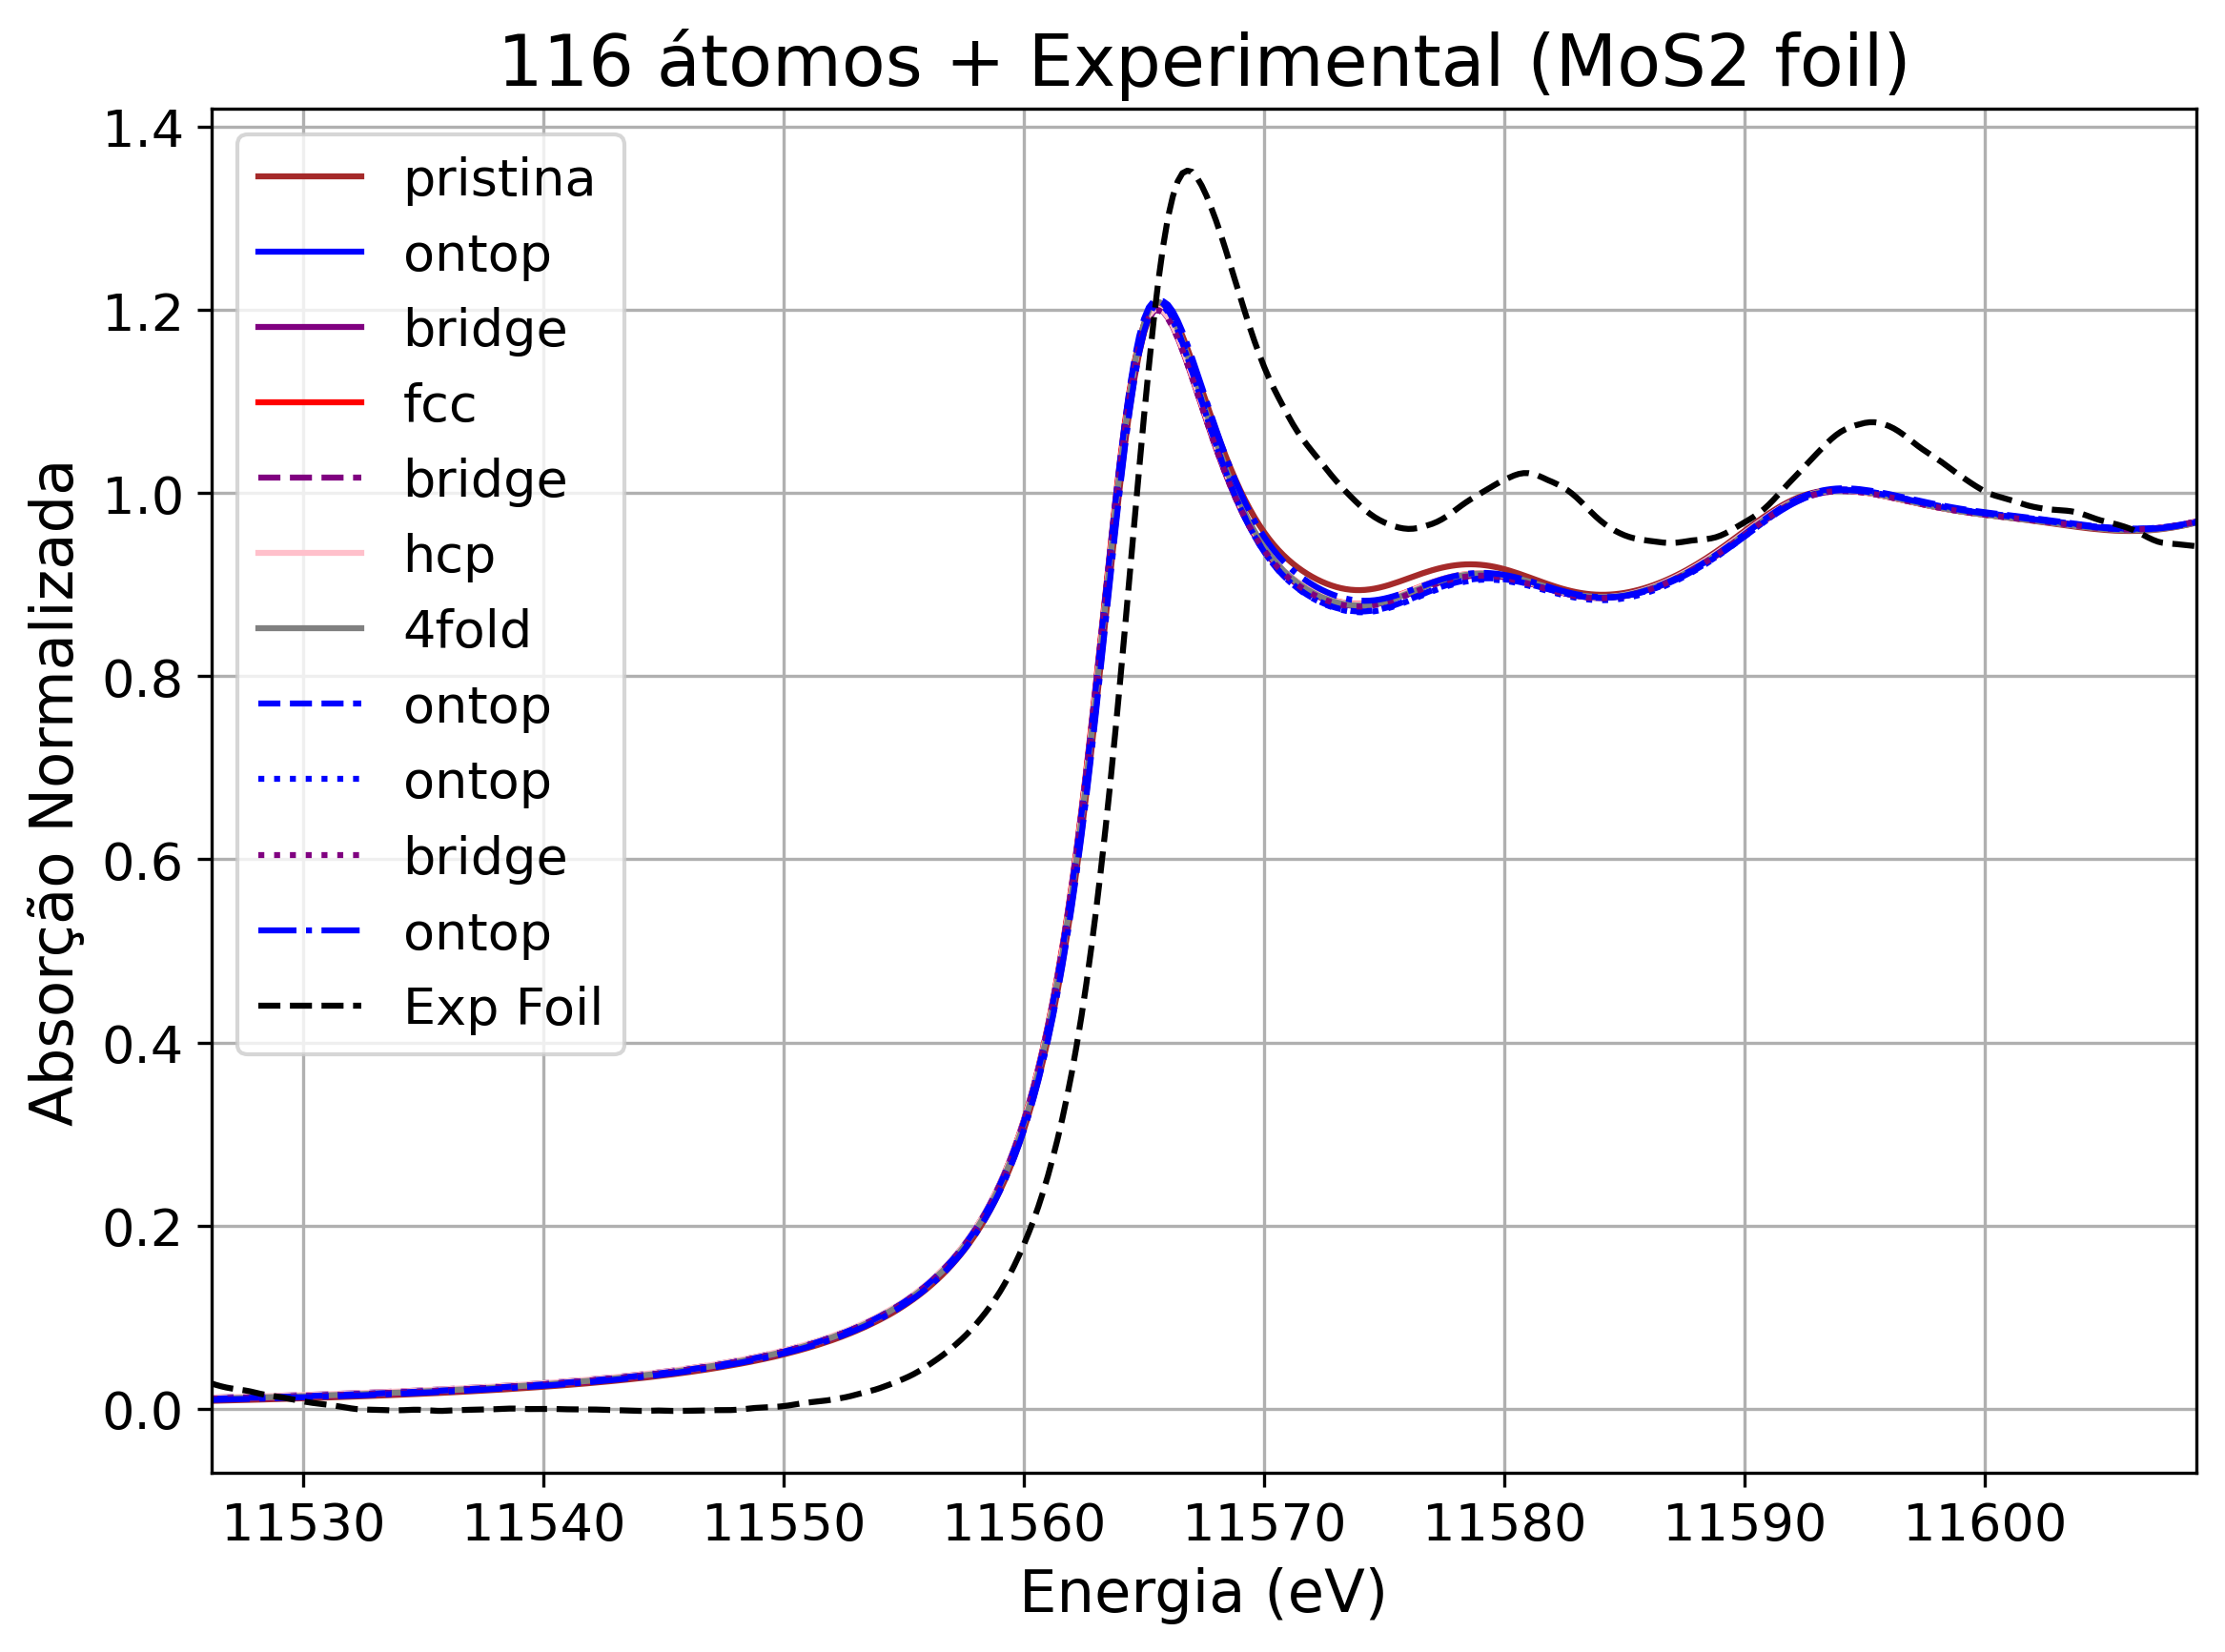

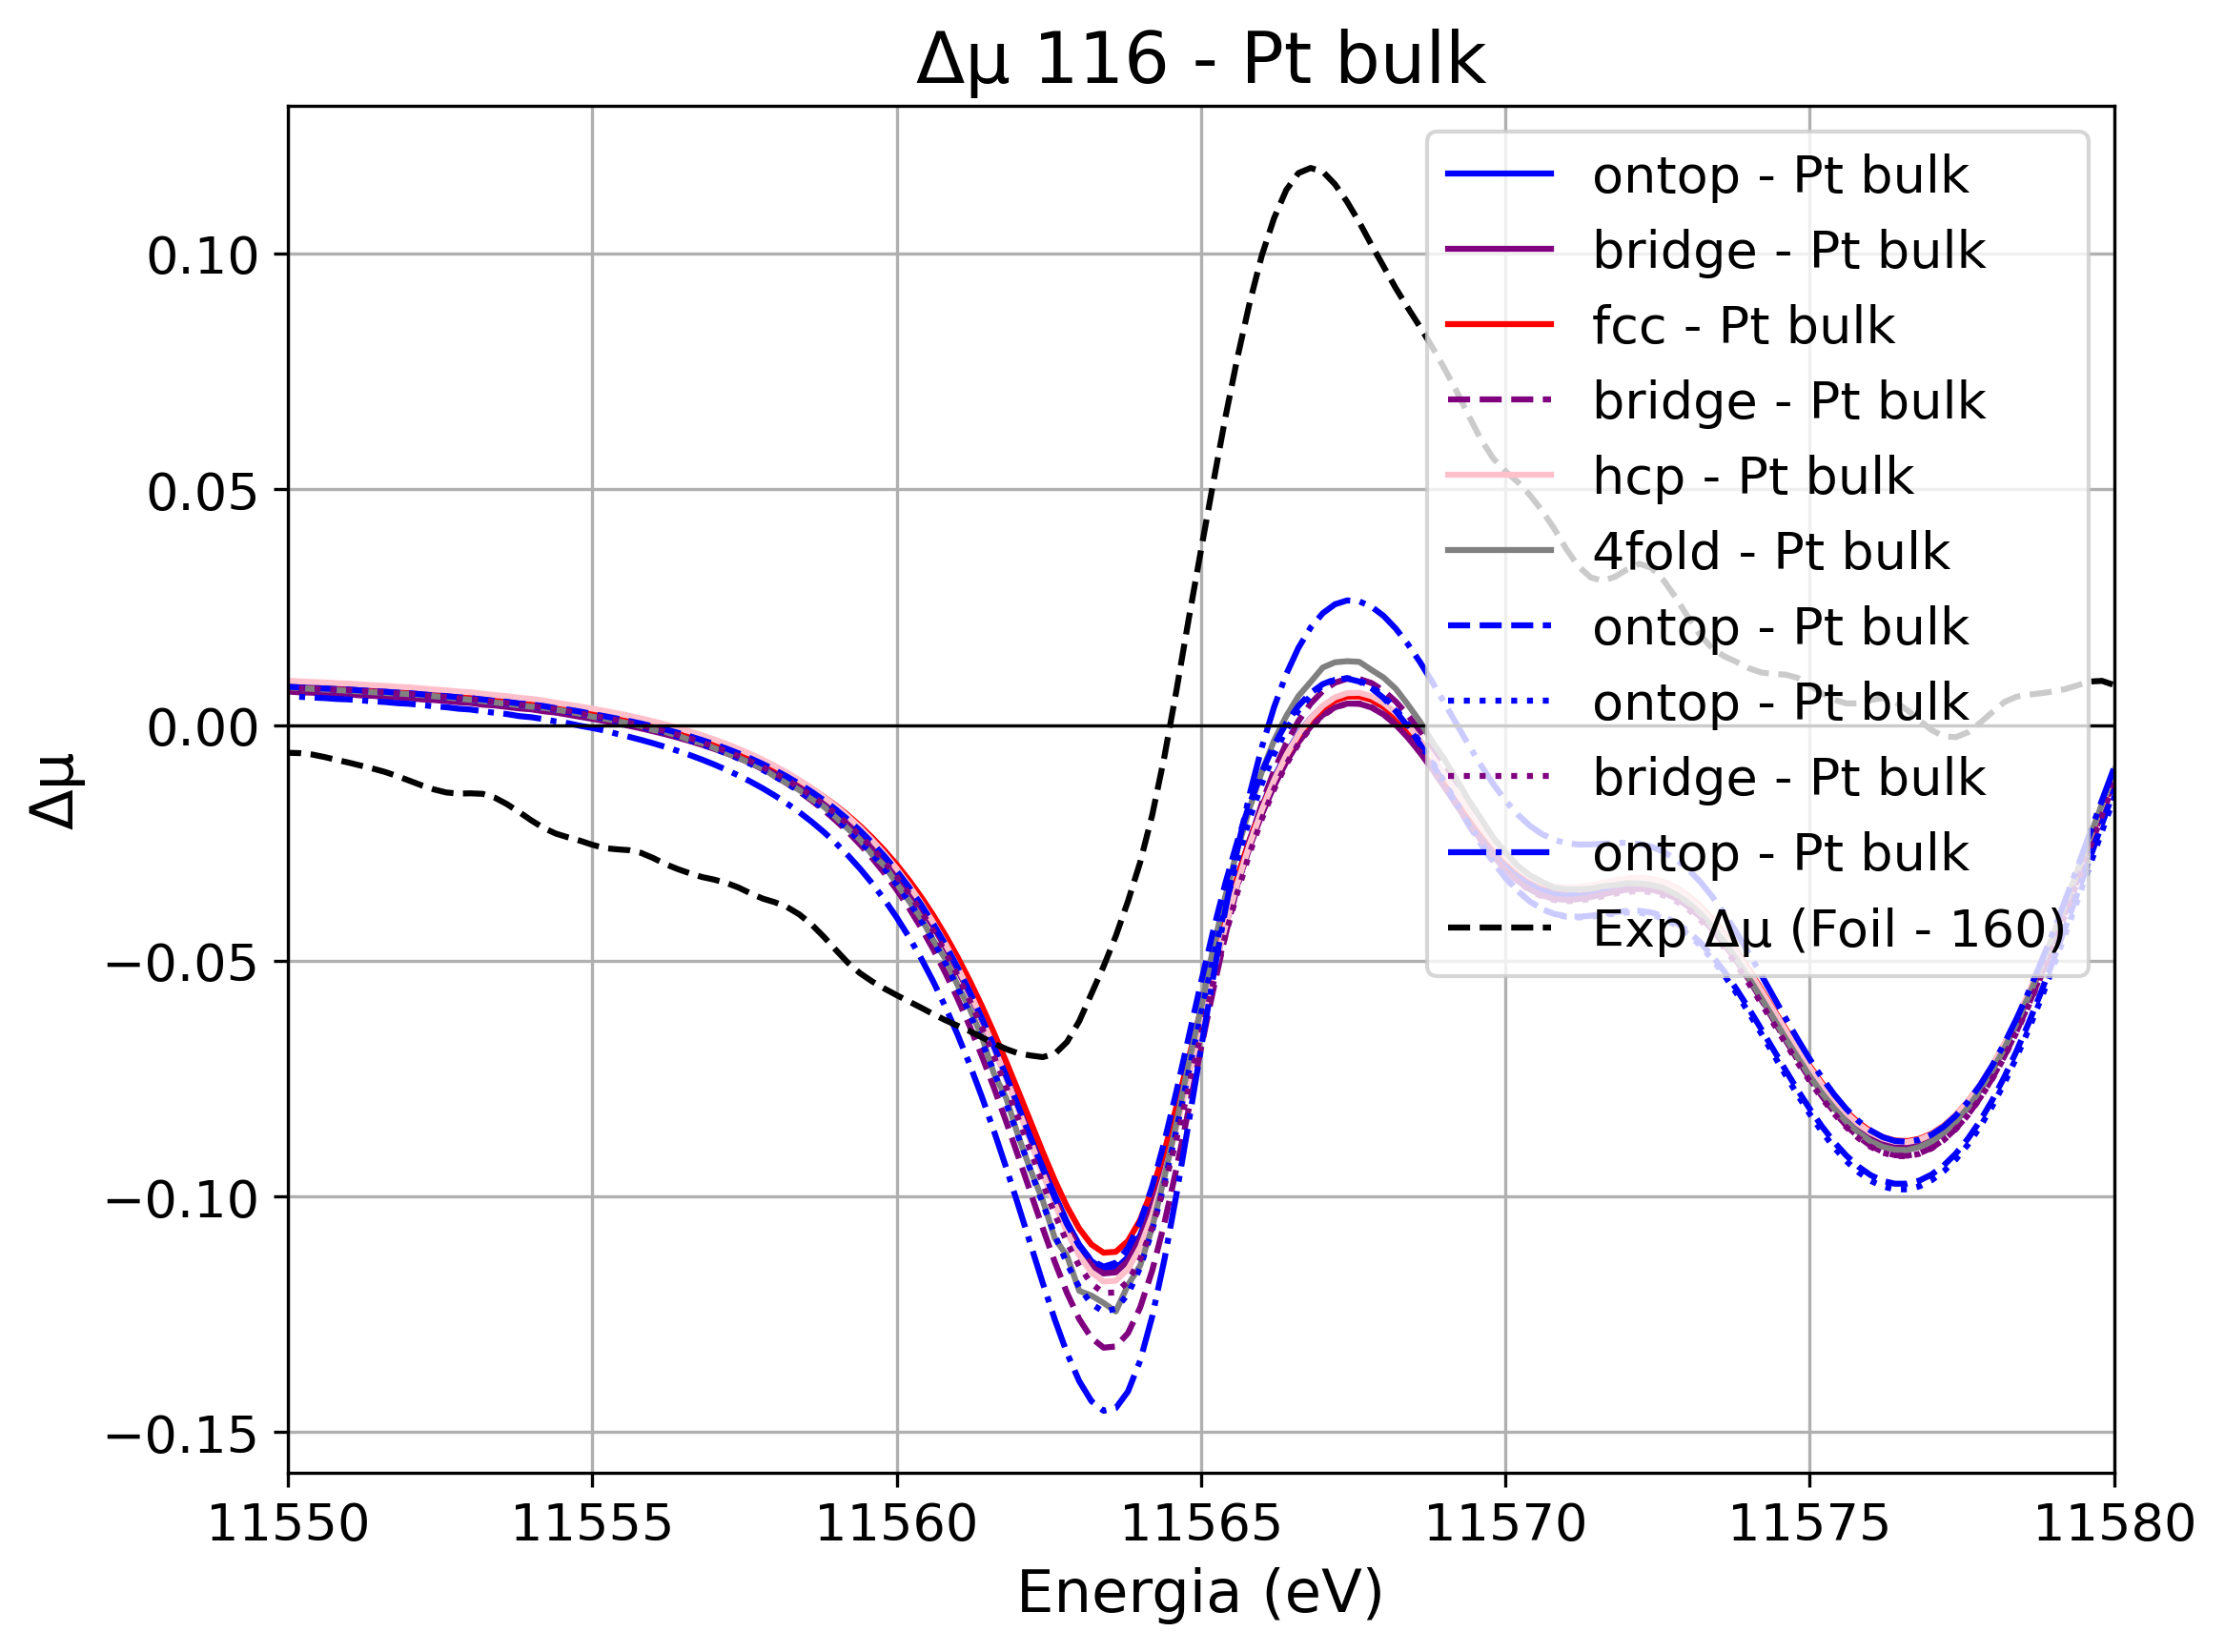

Todos os gráficos foram salvos em: plots_final


In [55]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict

# -------- CONFIG --------
NORM_DIR = "normalized"
PLOTS_DIR = "plots_final"
os.makedirs(PLOTS_DIR, exist_ok=True)

# -------- Mapas de rótulos dos sítios --------
site_labels_55 = {
    '00': 'pristina',
    '01': 'ontop',
    '02': 'bridge',
    '03': 'fcc',
    '04': 'hcp',
    '05': '4fold',
    '06': 'bridge',
    '07': 'ontop',
    '08': 'ontop',
}

site_labels_116 = {
    '00': 'pristina',
    '01': 'ontop',
    '02': 'bridge',
    '03': 'fcc',
    '04': 'bridge',
    '05': 'hcp',
    '06': '4fold',
    '07': 'ontop',
    '08': 'ontop',
    '09': 'bridge',
    '10': 'ontop',
}

# -------- Funções utilitárias --------
def load_norm_file(fname):
    data = np.loadtxt(fname, comments="#")
    E = data[:, 0]
    final = data[:, -1]
    return E, final

def interp_to_ref(E_ref, E, mu):
    return np.interp(E_ref, E, mu)

def site_label(fname):
    base = os.path.basename(fname)
    if base.startswith("55_"):
        parts = base.split("_")
        if len(parts) >= 2:
            key = parts[1]
            return site_labels_55.get(key, base.replace("_norm.txt",""))
    if base.startswith("116_"):
        parts = base.split("_")
        if len(parts) >= 2:
            key = parts[1]
            return site_labels_116.get(key, base.replace("_norm.txt",""))
    return base.replace("_norm.txt","")

# Paleta de cores
palette = [
    "brown",
    "blue",
    "purple",
    "r",
    "pink",
    "gray",
    "#17becf",
    "#bcbd22",
    "#393b79",
    "#637939",
]

linestyles = ['-', '--', ':', '-.']

def build_site_color_map():
    unique_sites = []
    for d in (site_labels_55, site_labels_116):
        for v in d.values():
            if v not in unique_sites:
                unique_sites.append(v)
    cmap = OrderedDict()
    pal_len = len(palette)
    for i, site in enumerate(unique_sites):
        cmap[site] = palette[i % pal_len]
    return cmap

SITE_COLOR = build_site_color_map()

# -------- Funções de plot --------
def plot_all(E, curves, labels, colors=None, lss=None, title="", fname="", exp_limits=None, fig_num=None, show=True):
    if fig_num is not None:
        plt.figure(fig_num, figsize=(8,6))
    else:
        plt.figure(figsize=(8,6))

    for i, mu in enumerate(curves):
        lbl = labels[i] if labels is not None else None
        color = colors[i] if (colors is not None and i < len(colors)) else None
        ls = lss[i] if (lss is not None and i < len(lss)) else '-'
        plt.plot(E, mu, label=lbl, color=color, linestyle=ls)

    if exp_limits is not None:
        plt.xlim(exp_limits)
    plt.xlabel("Energia (eV)")
    plt.ylabel("Absorção Normalizada")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(fname, dpi=300)
    if show:
        plt.show()
    else:
        plt.close()

def plot_delta(E, curves, labels, colors=None, lss=None, title="", fname="", exp_limits=None, fig_num=None, show=True):
    if fig_num is not None:
        plt.figure(fig_num, figsize=(8,6))
    else:
        plt.figure(figsize=(8,6))

    for i, mu in enumerate(curves):
        lbl = labels[i] if labels is not None else None
        color = colors[i] if (colors is not None and i < len(colors)) else None
        ls = lss[i] if (lss is not None and i < len(lss)) else '-'
        plt.plot(E, mu, label=lbl, color=color, linestyle=ls)

    if exp_limits is not None:
        plt.xlim(exp_limits)
    plt.axhline(0, color="k", linewidth=0.8)
    plt.xlabel("Energia (eV)")
    plt.ylabel("Δμ")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.xlim(11550, 11580)
    plt.tight_layout()
    plt.savefig(fname, dpi=300)
    if show:
        plt.show()
    else:
        plt.close()

# -------- Carregar arquivos --------
files = glob.glob(os.path.join(NORM_DIR, "*_norm.txt"))
files_55 = sorted([f for f in files if os.path.basename(f).startswith("55_")], key=os.path.basename)
files_116 = sorted([f for f in files if os.path.basename(f).startswith("116_")], key=os.path.basename)

# experimental e bulk
exp_files = [f for f in files if "XANES_Pt_Foil" in f or "XANES_Pt_MoS2(160)" in f]
if len(exp_files) < 2:
    raise RuntimeError("Arquivos experimentais não encontrados.")
bulk_candidates = [f for f in files if "Pt_bulk" in f]
if not bulk_candidates:
    raise RuntimeError("Arquivo Pt_bulk não encontrado.")
bulk_file = bulk_candidates[0]

# experimental
exp_mos2foil = [f for f in exp_files if "Foil(MoS2)" in f][0]
exp_mos2160 = [f for f in exp_files if "MoS2(160)" in f][0]
E_exp, mu_exp_foil = load_norm_file(exp_mos2foil)
_, mu_exp_160 = load_norm_file(exp_mos2160)
delta_exp = mu_exp_foil - mu_exp_160
exp_limits = (E_exp.min(), E_exp.max())

# Pt bulk
E_bulk, mu_bulk = load_norm_file(bulk_file)

def assign_styles(file_list):
    site_counter = defaultdict(int)
    colors = []
    lss = []
    labels = []
    for f in file_list:
        site = site_label(f)
        color = SITE_COLOR.get(site, "#333333")
        idx = site_counter[site]
        ls = linestyles[idx % len(linestyles)]
        site_counter[site] += 1
        colors.append(color)
        lss.append(ls)
        labels.append(site)
    return colors, lss, labels

# -------- Gráficos --------

# 1) todas as curvas 55 + experimental foil
curves_55_interp = [interp_to_ref(E_exp, *load_norm_file(f)) for f in files_55]
colors_55, lss_55, labels_55 = assign_styles(files_55)
curves1 = curves_55_interp + [mu_exp_foil]
colors1 = colors_55 + ['k']
lss1 = lss_55 + ['--']
labels1 = labels_55 + ['Exp Foil']

plot_all(E_exp, curves1, labels1, colors=colors1, lss=lss1,
         title="55 átomos + Experimental (MoS2 foil)",
         fname=os.path.join(PLOTS_DIR, "55_expfoil.png"),
         exp_limits=exp_limits, fig_num=1, show=True)

# 2) Δμ 55 - bulk + Δμ exp
delta_files_55 = [f for f in files_55 if os.path.basename(f).split("_")[1] != "00"]
curves = []
colors = []
lss = []
labels = []
site_counter = defaultdict(int)
mu_bulk_interp = interp_to_ref(E_exp, E_bulk, mu_bulk)
for f in delta_files_55:
    E, mu = load_norm_file(f)
    mu = interp_to_ref(E_exp, E, mu)
    curves.append(mu - mu_bulk_interp)
    site = site_label(f)
    color = SITE_COLOR.get(site, "#333333")
    idx = site_counter[site]
    ls = linestyles[idx % len(linestyles)]
    site_counter[site] += 1
    colors.append(color)
    lss.append(ls)
    labels.append(f"{site} - Pt bulk")

curves.append(delta_exp)
colors.append('k')
lss.append('--')
labels.append("Exp Δμ (160 - Foil)")

plot_delta(E_exp, curves, labels, colors=colors, lss=lss,
           title="Δμ 55 - Pt bulk", fname=os.path.join(PLOTS_DIR, "55_delta_bulk.png"),
           exp_limits=exp_limits, fig_num=2, show=True)

# 3) todas as curvas 116 + experimental foil
curves_116_interp = [interp_to_ref(E_exp, *load_norm_file(f)) for f in files_116]
colors_116, lss_116, labels_116 = assign_styles(files_116)
curves3 = curves_116_interp + [mu_exp_foil]
colors3 = colors_116 + ['k']
lss3 = lss_116 + ['--']
labels3 = labels_116 + ['Exp Foil']

plot_all(E_exp, curves3, labels3, colors=colors3, lss=lss3,
         title="116 átomos + Experimental (MoS2 foil)",
         fname=os.path.join(PLOTS_DIR, "116_expfoil.png"),
         exp_limits=exp_limits, fig_num=3, show=True)

# 4) Δμ 116 - bulk + Δμ exp
delta_files_116 = [f for f in files_116 if os.path.basename(f).split("_")[1] != "00"]
curves = []
colors = []
lss = []
labels = []
site_counter = defaultdict(int)
mu_bulk_interp = interp_to_ref(E_exp, E_bulk, mu_bulk)
for f in delta_files_116:
    E, mu = load_norm_file(f)
    mu = interp_to_ref(E_exp, E, mu)
    curves.append(mu - mu_bulk_interp)
    site = site_label(f)
    color = SITE_COLOR.get(site, "#333333")
    idx = site_counter[site]
    ls = linestyles[idx % len(linestyles)]
    site_counter[site] += 1
    colors.append(color)
    lss.append(ls)
    labels.append(f"{site} - Pt bulk")

curves.append(delta_exp)
colors.append('k')
lss.append('--')
labels.append("Exp Δμ (160 - Foil)")

plot_delta(E_exp, curves, labels, colors=colors, lss=lss,
           title="Δμ 116 - Pt bulk", fname=os.path.join(PLOTS_DIR, "116_delta_bulk.png"),
           exp_limits=exp_limits, fig_num=4, show=True)

print("Todos os gráficos foram salvos em:", PLOTS_DIR)


[55atoms] pontos = 414 | sítios = 8


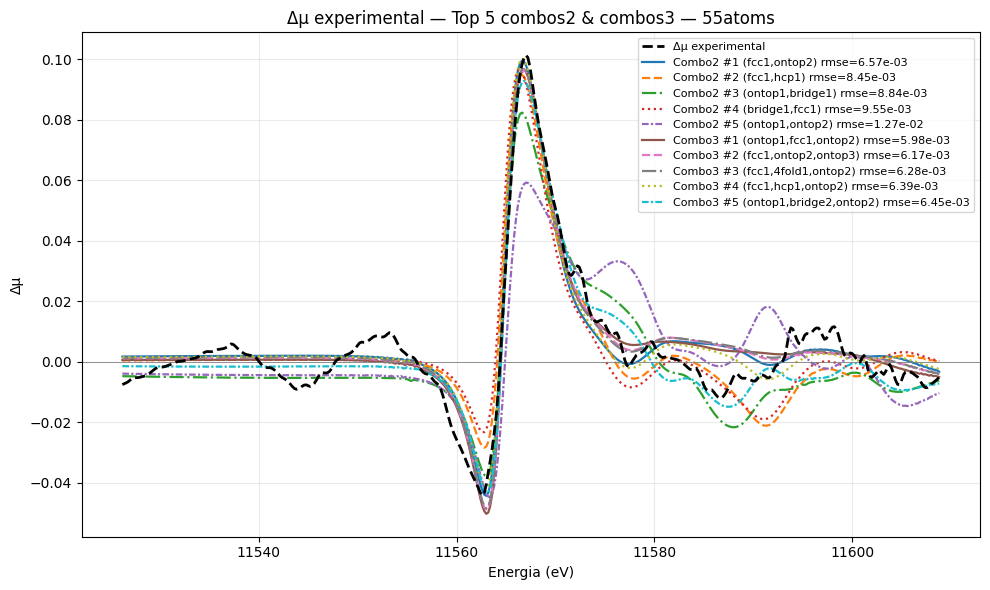

[55atoms] plot salvo: plots_final\delta_top5_combos_55atoms.png
[116atoms] pontos = 414 | sítios = 10


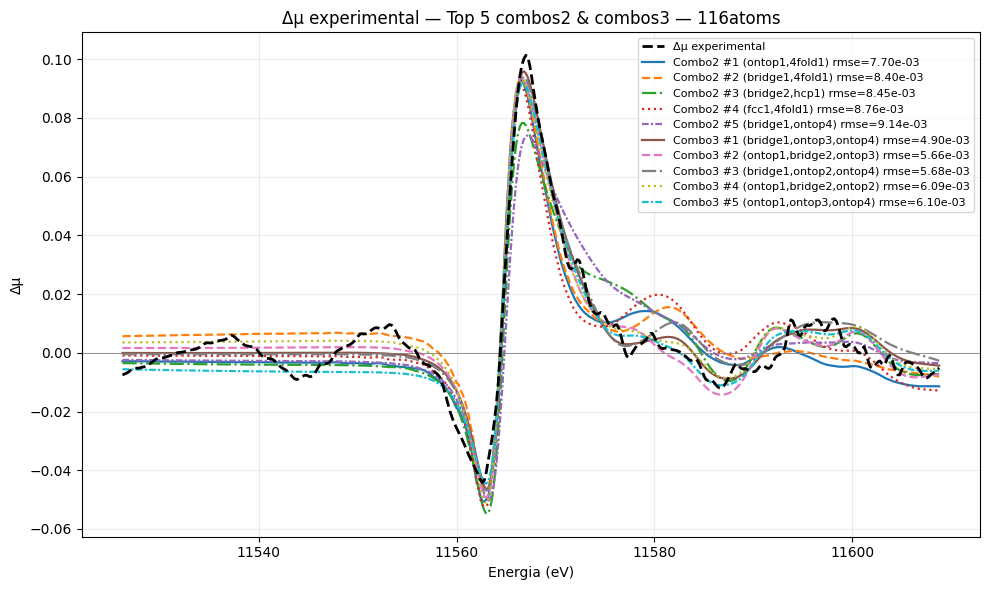

[116atoms] plot salvo: plots_final\delta_top5_combos_116atoms.png
Pronto — plots gerados em: plots_final


In [75]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
delta_best_combos_plot_only.py

- Carrega arquivos normalizados em 'normalized'.
- Constrói Δµ experimental (foil - outra) usando bulk de referência.
- Constrói matrizes Δµ por sítio (55 e 116).
- Encontra melhores combinações (2 e 3) por RMSE (LSQ).
- Plota: Δµ experimental (tracejada) + top5 combo2 + top5 combo3.
- Aplica suavização apenas nos combos do conjunto '116atoms'.
"""
import os
import glob
import itertools
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

# -------- CONFIG --------
NORM_DIR = "normalized"
PLOTS_DIR = "plots_final"
os.makedirs(PLOTS_DIR, exist_ok=True)

ENERGY_RANGE = (11500.0, 11620.0)   # definir None para usar todo o intervalo
TOP_N_COMBOS = 1000
TOP_TO_PLOT = 5   # <-- agora plota os 5 melhores combos

# -------- Mapas de rótulos (ajuste se necessário) --------
site_labels_55 = {
    '00': 'pristina', '01': 'ontop', '02': 'bridge', '03': 'fcc',
    '04': 'hcp', '05': '4fold', '06': 'bridge', '07': 'ontop', '08': 'ontop'
}
site_labels_116 = {
    '00': 'pristina', '01': 'ontop', '02': 'bridge', '03': 'fcc',
    '04': 'bridge', '05': 'hcp', '06': '4fold', '07': 'ontop',
    '08': 'ontop', '09': 'bridge', '10': 'ontop'
}


# -------- utilitárias --------
def load_norm_file(fname):
    data = np.loadtxt(fname, comments="#")
    E = data[:, 0]
    final = data[:, -1]
    return E, final

def interp_to_ref(E_ref, E, mu):
    return np.interp(E_ref, E, mu)

def site_label(fname):
    base = os.path.basename(fname)
    if base.startswith("55_"):
        parts = base.split("_")
        if len(parts) >= 2:
            return site_labels_55.get(parts[1], base.replace("_norm.txt",""))
    if base.startswith("116_"):
        parts = base.split("_")
        if len(parts) >= 2:
            return site_labels_116.get(parts[1], base.replace("_norm.txt",""))
    return base.replace("_norm.txt","")

def rmse(a, b):
    return float(np.sqrt(np.mean((a - b)**2)))

def make_unique_names(names):
    """Converte ['ontop','bridge','ontop'] -> ['ontop1','bridge1','ontop2']"""
    counts = {}
    out = []
    for n in names:
        c = counts.get(n, 0) + 1
        counts[n] = c
        out.append(f"{n}{c}")
    return out

def choose_savgol_window(n, preferred=11, polyorder=3):
    if n < 3:
        return None
    w = min(preferred, n)
    if w % 2 == 0:
        w -= 1
    if w <= polyorder:
        w = polyorder + 1
        if w % 2 == 0:
            w += 1
    if w > n:
        w = n if n % 2 == 1 else n - 1
    if w < 3 or w <= polyorder:
        return None
    return w

def smooth_signal(y, preferred_window=11, polyorder=3):
    n = len(y)
    w = choose_savgol_window(n, preferred_window, polyorder)
    if w is None:
        return y
    try:
        return savgol_filter(y, window_length=w, polyorder=polyorder)
    except Exception:
        return y

# -------- Ler arquivos --------
files = glob.glob(os.path.join(NORM_DIR, "*_norm.txt"))
files_55 = sorted([f for f in files if os.path.basename(f).startswith("55_")])
files_116 = sorted([f for f in files if os.path.basename(f).startswith("116_")])

# detectar experimentais e bulk
exp_files = [f for f in files if ("XANES_Pt_Foil" in f) or ("XANES_Pt_MoS2" in f) or ("Foil" in f and "MoS2" in f)]
if len(exp_files) < 2:
    exp_files = [f for f in files if "Foil" in os.path.basename(f) or "160" in os.path.basename(f)]
if len(exp_files) < 2:
    raise RuntimeError("Arquivos experimentais não encontrados em 'normalized'.")
bulk_candidates = [f for f in files if "Pt_bulk" in f or "bulk" in os.path.basename(f).lower()]
if not bulk_candidates:
    raise RuntimeError("Arquivo Pt_bulk não encontrado em 'normalized'.")
bulk_file = bulk_candidates[0]

# escolher dois experimentais (foil e outro)
exp_foil = None
exp_other = None
for f in exp_files:
    b = os.path.basename(f)
    if "Foil" in b or "foil" in b:
        exp_foil = f
    if "160" in b or "MoS2" in b or "moS2" in b:
        exp_other = f
if exp_foil is None or exp_other is None:
    exp_foil, exp_other = exp_files[:2]

E_exp_full, mu_exp_foil = load_norm_file(exp_foil)
_, mu_exp_other = load_norm_file(exp_other)
delta_exp_full = mu_exp_foil - mu_exp_other

E_bulk, mu_bulk = load_norm_file(bulk_file)
mu_bulk_interp_full = interp_to_ref(E_exp_full, E_bulk, mu_bulk)

# -------- Construir Δµ de cada sítio --------
def build_delta_matrix_for_files(files_list, E_ref, mu_bulk_interp_ref):
    curves, names = [], []
    for f in files_list:
        parts = os.path.basename(f).split("_")
        if len(parts) >= 2 and parts[1] == "00":
            continue
        E, mu = load_norm_file(f)
        mu_interp = interp_to_ref(E_ref, E, mu)
        delta = mu_interp - mu_bulk_interp_ref
        curves.append(delta)
        names.append(site_label(f))
    if len(curves) == 0:
        return np.zeros((len(E_ref), 0)), []
    unique = make_unique_names(names)
    return np.array(curves).T, unique

delta_55_full, names_55 = build_delta_matrix_for_files(files_55, E_exp_full, mu_bulk_interp_full)
delta_116_full, names_116 = build_delta_matrix_for_files(files_116, E_exp_full, mu_bulk_interp_full)

# -------- Funções --------
def apply_energy_cut(E_full, y_full, X_full, energy_range):
    if energy_range is None:
        return E_full, y_full, X_full
    emin, emax = energy_range
    mask = (E_full >= emin) & (E_full <= emax)
    if mask.sum() == 0:
        raise RuntimeError(f"Nenhum ponto dentro do intervalo {energy_range}.")
    Xcut = X_full[mask, :] if X_full.size else X_full
    return E_full[mask], y_full[mask], Xcut

def best_combinations_by_rmse(X, y, names, comb_size=2, top_n=10):
    if X.size == 0 or X.shape[1] < comb_size:
        return []
    n_sites = X.shape[1]
    combos = list(itertools.combinations(range(n_sites), comb_size))
    out = []
    for comb in combos:
        cols = list(comb)
        Xsub = X[:, cols]
        sol, *_ = np.linalg.lstsq(Xsub, y, rcond=None)
        ypred = Xsub.dot(sol)
        lsq_rmse = rmse(y, ypred)
        out.append({
            "indices": cols,
            "sites": [names[i] for i in cols],
            "lsq_coefs": np.asarray(sol),
            "lsq_rmse": float(lsq_rmse)
        })
    out_sorted = sorted(out, key=lambda x: x["lsq_rmse"])
    return out_sorted[:min(top_n, len(out_sorted))]

def plot_best_combos(E_full, delta_exp_full, delta_matrix_full, names, set_label, smooth_combos=False):
    E, y, X = apply_energy_cut(E_full, delta_exp_full, delta_matrix_full, ENERGY_RANGE)
    print(f"[{set_label}] pontos = {len(E)} | sítios = {len(names)}")

    combos_2 = best_combinations_by_rmse(X, y, names, comb_size=2, top_n=TOP_N_COMBOS)
    combos_3 = best_combinations_by_rmse(X, y, names, comb_size=3, top_n=TOP_N_COMBOS)

    plt.figure(figsize=(10,6))
    # experimental
    plt.plot(E, y, linestyle='--', color='black', linewidth=2.0,
             label="Δµ experimental", zorder=10)

    # plotar até TOP_TO_PLOT combos2
    linestyles = ['-', '--', '-.', ':', (0,(3,1,1,1))]
    colors = plt.cm.tab10.colors
    for i, combo in enumerate(combos_2[:TOP_TO_PLOT]):
        cols = combo["indices"]
        y_pred = X[:, cols].dot(combo["lsq_coefs"])
        if smooth_combos:
            y_pred = smooth_signal(y_pred, preferred_window=15, polyorder=3)
        plt.plot(E, y_pred, linestyle=linestyles[i % len(linestyles)],
                 color=colors[i % len(colors)], linewidth=1.6,
                 label=f"Combo2 #{i+1} ({','.join(combo['sites'])}) rmse={combo['lsq_rmse']:.2e}")

    # plotar até TOP_TO_PLOT combos3
    for i, combo in enumerate(combos_3[:TOP_TO_PLOT]):
        cols = combo["indices"]
        y_pred = X[:, cols].dot(combo["lsq_coefs"])
        if smooth_combos:
            y_pred = smooth_signal(y_pred, preferred_window=15, polyorder=3)
        plt.plot(E, y_pred, linestyle=linestyles[i % len(linestyles)],
                 color=colors[(i+5) % len(colors)], linewidth=1.6,
                 label=f"Combo3 #{i+1} ({','.join(combo['sites'])}) rmse={combo['lsq_rmse']:.2e}")

    plt.axhline(0, color='gray', lw=0.6)
    plt.xlabel("Energia (eV)")
    plt.ylabel("Δµ")
    plt.title(f"Δµ experimental — Top {TOP_TO_PLOT} combos2 & combos3 — {set_label}")
    plt.legend(fontsize=8, loc='best')
    plt.grid(alpha=0.25)
    plt.tight_layout()
    figfile = os.path.join(PLOTS_DIR, f"delta_top{TOP_TO_PLOT}_combos_{set_label}.png")
    plt.savefig(figfile, dpi=300)
    plt.show()
    print(f"[{set_label}] plot salvo: {figfile}")


# -------- Executar --------
plot_best_combos(E_exp_full, delta_exp_full, delta_55_full, names_55,
                 set_label="55atoms", smooth_combos=False)
plot_best_combos(E_exp_full, delta_exp_full, delta_116_full, names_116,
                 set_label="116atoms", smooth_combos=True)

print("Pronto — plots gerados em:", PLOTS_DIR)
